In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm catboost optuna imbalanced-learn opendatasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 36.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error

import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/competitions/playground-series-s5e10/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: imalkawelikala
Your Kaggle Key: ··········


100%|██████████| 7.76M/7.76M [00:00<00:00, 888MB/s]


Extracting archive ./playground-series-s5e10/playground-series-s5e10.zip to ./playground-series-s5e10


In [ ]:
os.listdir('./playground-series-s5e10')

['train.csv', 'sample_submission.csv', 'test.csv']

In [ ]:
train_df = pd.read_csv("playground-series-s5e10/train.csv")
test_df = pd.read_csv("playground-series-s5e10/test.csv")

print(train_df.shape, test_df.shape)

(517754, 14) (172585, 13)



1. Dataset Overview

Train Dataset Preview:


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30



Shape: (517754, 14)

Data Types:
id                          int64
road_type                  object
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                   object
weather                    object
road_signs_present           bool
public_road                  bool
time_of_day                object
holiday                      bool
school_season                bool
num_reported_accidents      int64
accident_risk             float64
dtype: object

Test Dataset Preview:


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1



Shape: (172585, 13)

Data Types:
id                          int64
road_type                  object
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                   object
weather                    object
road_signs_present           bool
public_road                  bool
time_of_day                object
holiday                      bool
school_season                bool
num_reported_accidents      int64
dtype: object

Missing Values (Train):
id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

Missing Values (Test):
id                        0
road_type                 0


,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849974,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000



Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool

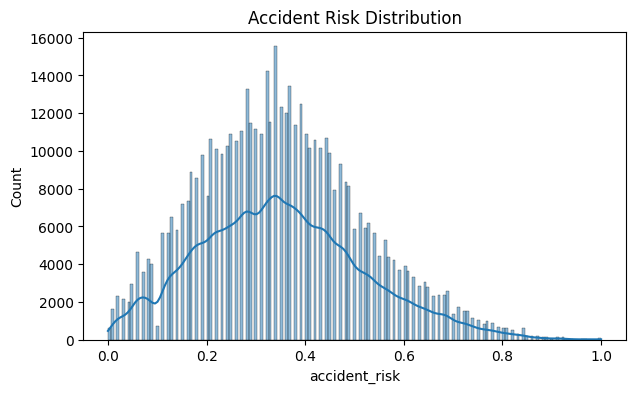

In [ ]:
# ==================================================
# 4. Dataset Overview
# ==================================================
print("\n\033[1m1. Dataset Overview\033[0m")
print("=" * 60)

def dataset_overview(train, test):

    print("\nTrain Dataset Preview:")
    display(train.head(3))
    print(f"\nShape: {train.shape}")
    print("\nData Types:")
    print(train.dtypes)

    print("\nTest Dataset Preview:")
    display(test.head(3))
    print(f"\nShape: {test.shape}")
    print("\nData Types:")
    print(test.dtypes)

    print("\nMissing Values (Train):")
    print(train.isnull().sum())

    print("\nMissing Values (Test):")
    print(test.isnull().sum())

    print(f"\nDuplicate rows in train: {train.duplicated().sum()}")
    print(f"Duplicate rows in test: {test.duplicated().sum()}")

    print("\nTrain Dataset Statistics:")
    display(train.describe())

    print("\nTrain Info:")
    train.info()
    print("\nTest Info:")
    test.info()

    if 'accident_risk' in train.columns:
        print("\nTarget Variable (accident_risk) Summary:")
        print(train['accident_risk'].describe())

        plt.figure(figsize=(7,4))
        sns.histplot(train['accident_risk'], kde=True)
        plt.title("Accident Risk Distribution")
        plt.xlabel("accident_risk")
        plt.show()

    if 'id' in train.columns:
        train.drop(columns=['id'], inplace=True)

    if 'id' in test.columns:
        test.drop(columns=['id'], inplace=True)

dataset_overview(train_df, test_df)

In [ ]:
# ==================================================
# Identify categorical and numerical features
# ==================================================
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target column safely
if 'accident_risk' in numerical_features:
    numerical_features.remove('accident_risk')

# Optional: remove ID if present
if 'id' in numerical_features:
    numerical_features.remove('id')

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)


Categorical Features: ['road_type', 'lighting', 'weather', 'time_of_day']
Numerical Features: ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']



3. Feature Distributions

Train Dataset Feature Distributions:


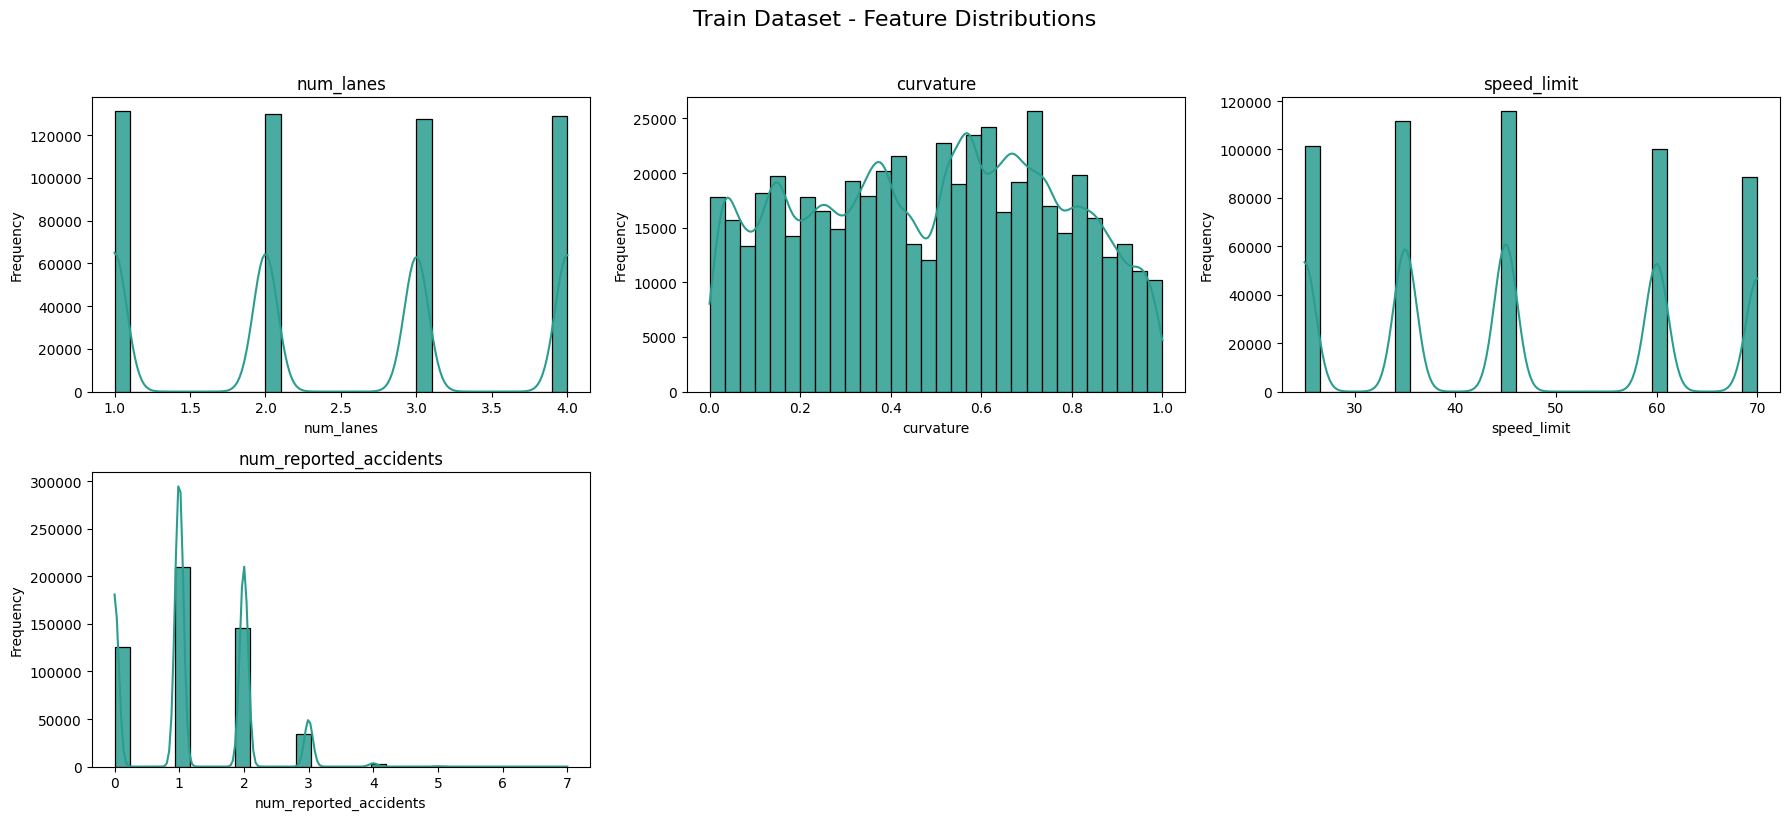


Test Dataset Feature Distributions:


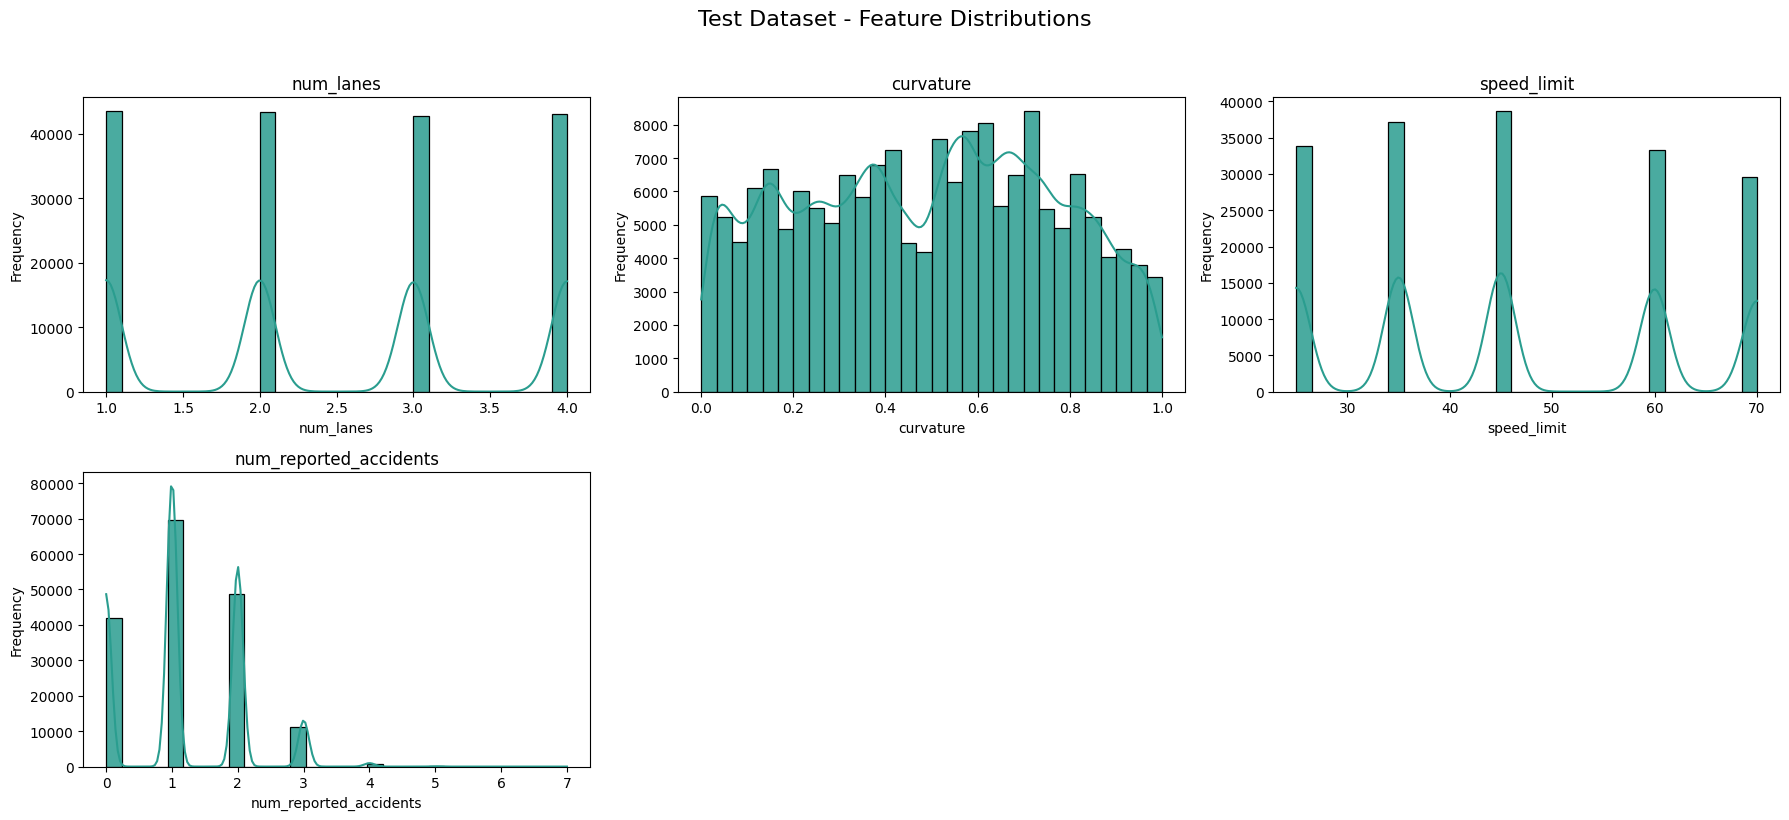

In [ ]:
# ==================================================
# 3. Feature Distributions (Train & Test)
# ==================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("\n\033[1m3. Feature Distributions\033[0m")
print("=" * 50)

def plot_feature_distributions(data, title, numerical_cols, max_features=9):
    """
    Plots histogram distributions for numerical features.
    Limited to max_features to avoid Colab rendering issues.
    """

    if len(numerical_cols) == 0:
        print("❌ No numerical features to plot.")
        return

    # Limit number of plotted features
    numerical_cols = numerical_cols[:max_features]

    cols = 3
    rows = (len(numerical_cols) + cols - 1) // cols

    plt.figure(figsize=(18, rows * 4))
    plt.suptitle(f"{title} - Feature Distributions", y=1.02, fontsize=16)

    for i, col in enumerate(numerical_cols):
        plt.subplot(rows, cols, i + 1)

        sns.histplot(
            data[col].dropna(),
            bins=30,
            kde=True,
            color="#2a9d8f",
            edgecolor="black",
            alpha=0.85
        )

        plt.title(col)
        plt.xlabel(col)
        plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


# ==================================================
# Plot TRAIN dataset distributions
# ==================================================
print("\nTrain Dataset Feature Distributions:")
plot_feature_distributions(
    train_df,
    "Train Dataset",
    numerical_features,
    max_features=9
)

# ==================================================
# Plot TEST dataset distributions
# ==================================================
print("\nTest Dataset Feature Distributions:")
plot_feature_distributions(
    test_df,
    "Test Dataset",
    numerical_features,
    max_features=9
)



4. Target Variable Analysis


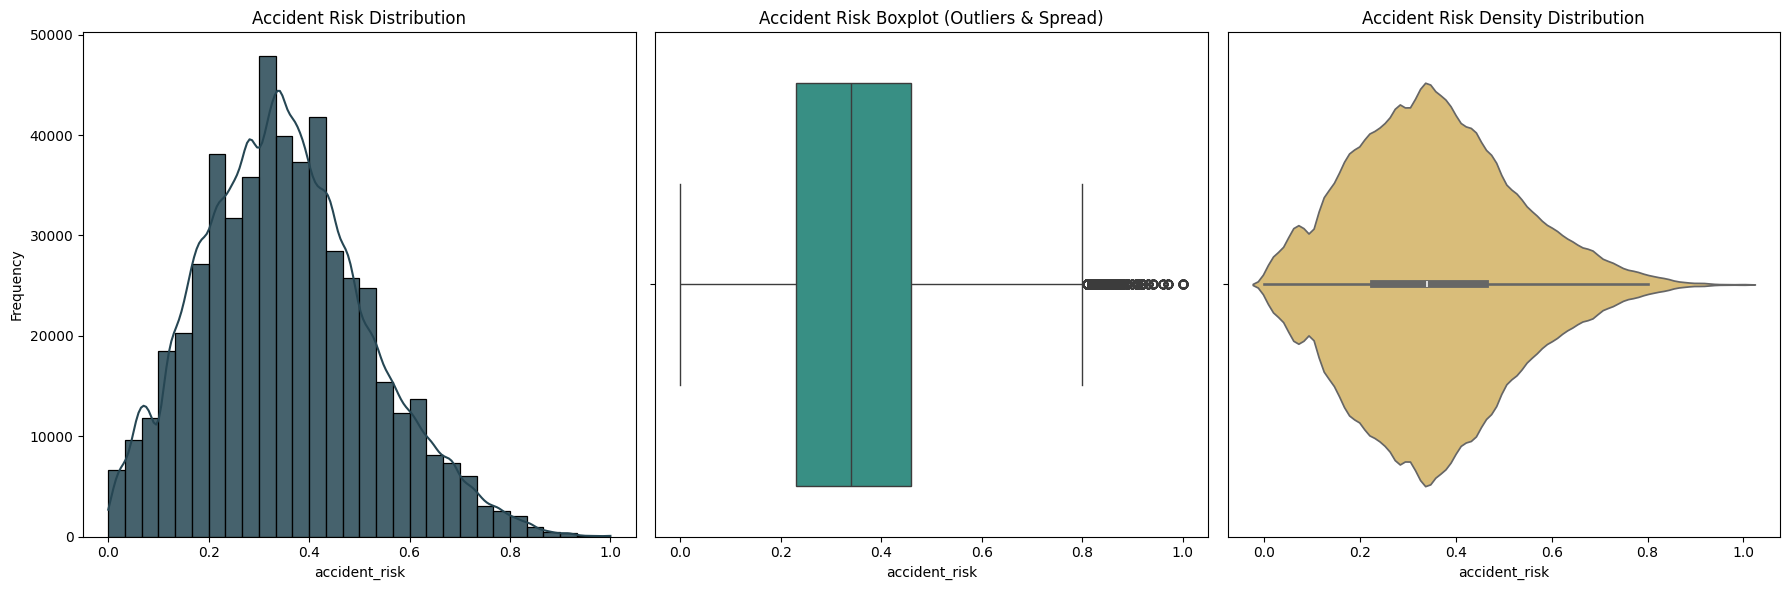


Target Variable Statistics (accident_risk):
count    517754.000000
mean          0.352377
std           0.166417
min           0.000000
25%           0.230000
50%           0.340000
75%           0.460000
max           1.000000
Name: accident_risk, dtype: float64

Additional Insights:
Skewness : 0.378
Kurtosis : -0.077


In [ ]:
# ==================================================
# 4. Target Variable Analysis (accident_risk)
# ==================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("\n\033[1m4. Target Variable Analysis\033[0m")
print("=" * 50)

def analyze_target_variable(data, target_col="accident_risk"):

    if target_col not in data.columns:
        print(f"Target column '{target_col}' not found in dataset.")
        return

    plt.figure(figsize=(18, 6))

    # -----------------------------
    # Distribution Histogram + KDE
    # -----------------------------
    plt.subplot(1, 3, 1)
    sns.histplot(
        data[target_col],
        bins=30,
        kde=True,
        color="#264653",
        edgecolor="black",
        alpha=0.85
    )
    plt.title("Accident Risk Distribution")
    plt.xlabel("accident_risk")
    plt.ylabel("Frequency")

    # -----------------------------
    # Boxplot (Outliers & Spread)
    # -----------------------------
    plt.subplot(1, 3, 2)
    sns.boxplot(
        x=data[target_col],
        color="#2a9d8f"
    )
    plt.title("Accident Risk Boxplot (Outliers & Spread)")
    plt.xlabel("accident_risk")

    # -----------------------------
    # Violin Plot (Density)
    # -----------------------------
    plt.subplot(1, 3, 3)
    sns.violinplot(
        x=data[target_col],
        color="#e9c46a"
    )
    plt.title("Accident Risk Density Distribution")
    plt.xlabel("accident_risk")

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Statistical Summary
    # -----------------------------
    print("\nTarget Variable Statistics (accident_risk):")
    print(data[target_col].describe())

    print("\nAdditional Insights:")
    print(f"Skewness : {data[target_col].skew():.3f}")
    print(f"Kurtosis : {data[target_col].kurtosis():.3f}")


# ==================================================
# Run Target Analysis
# ==================================================
analyze_target_variable(train_df)



2. Numerical Features Analysis

Train Data Numerical Features:


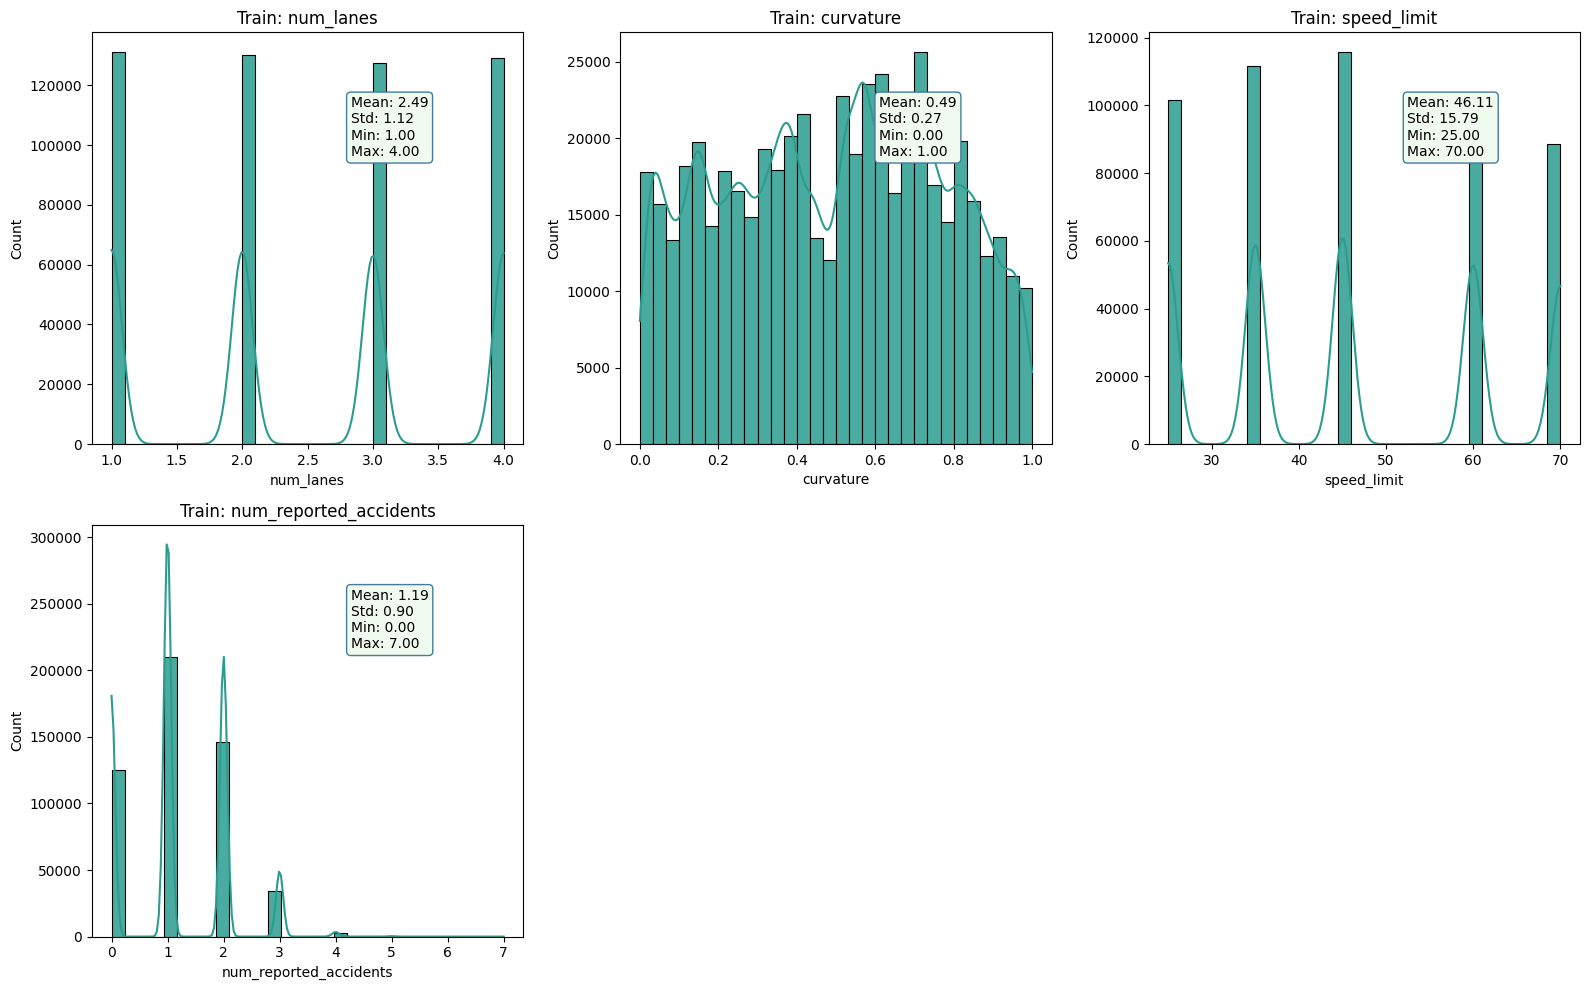


Test Data Numerical Features:


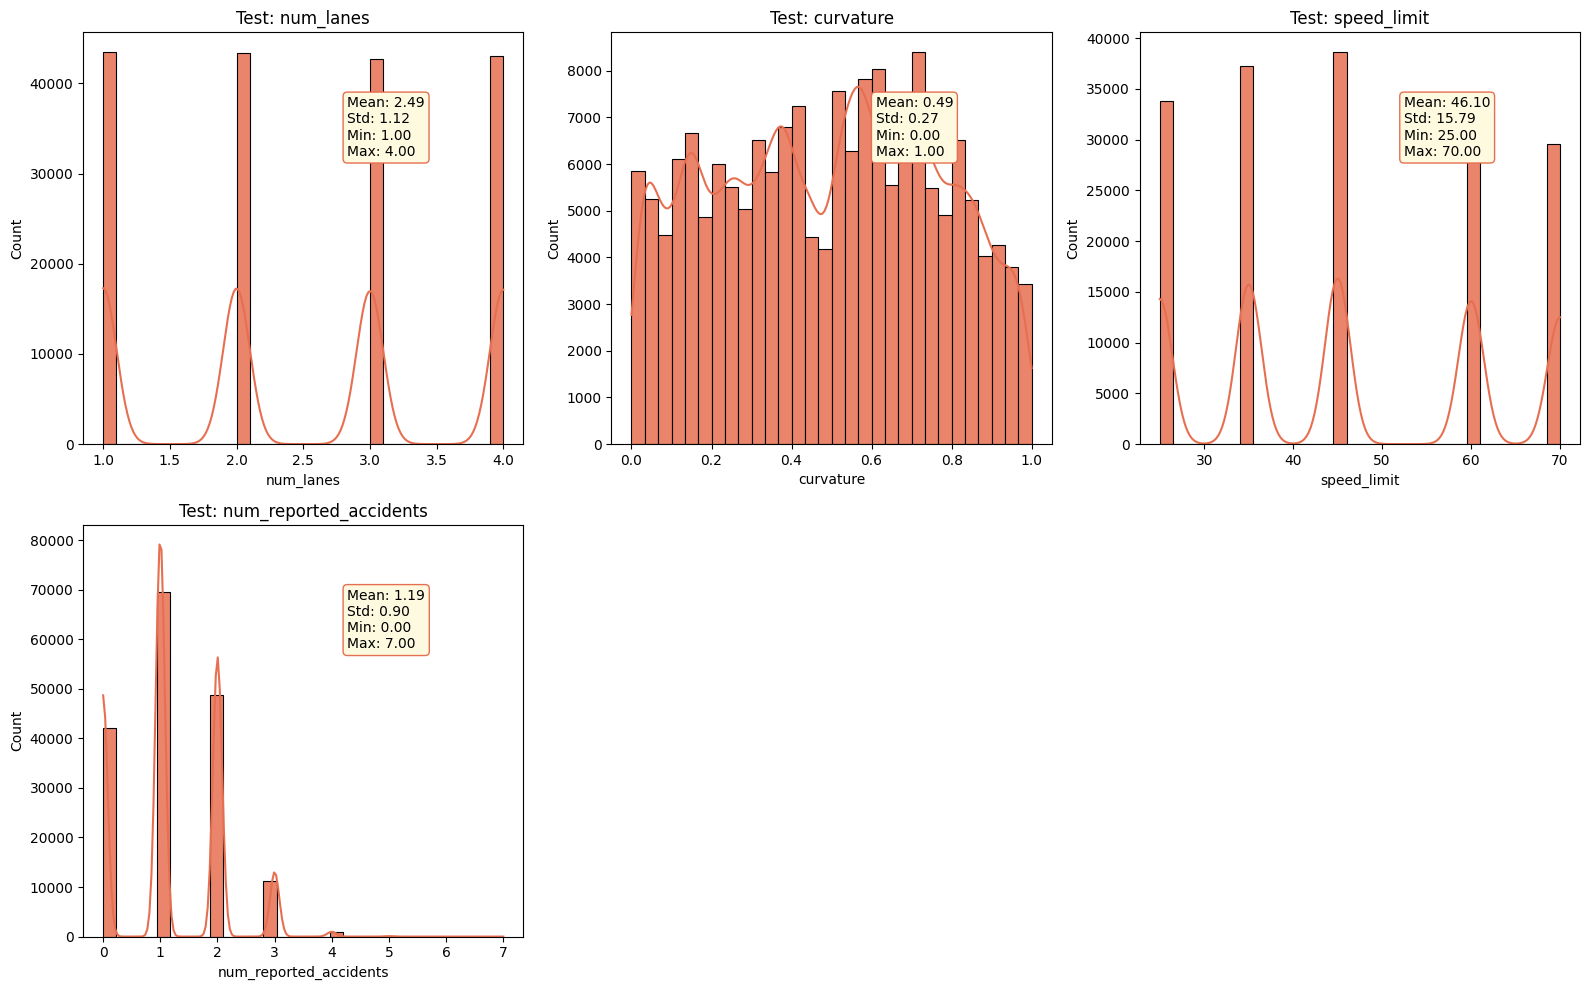


Train vs Test Comparison:


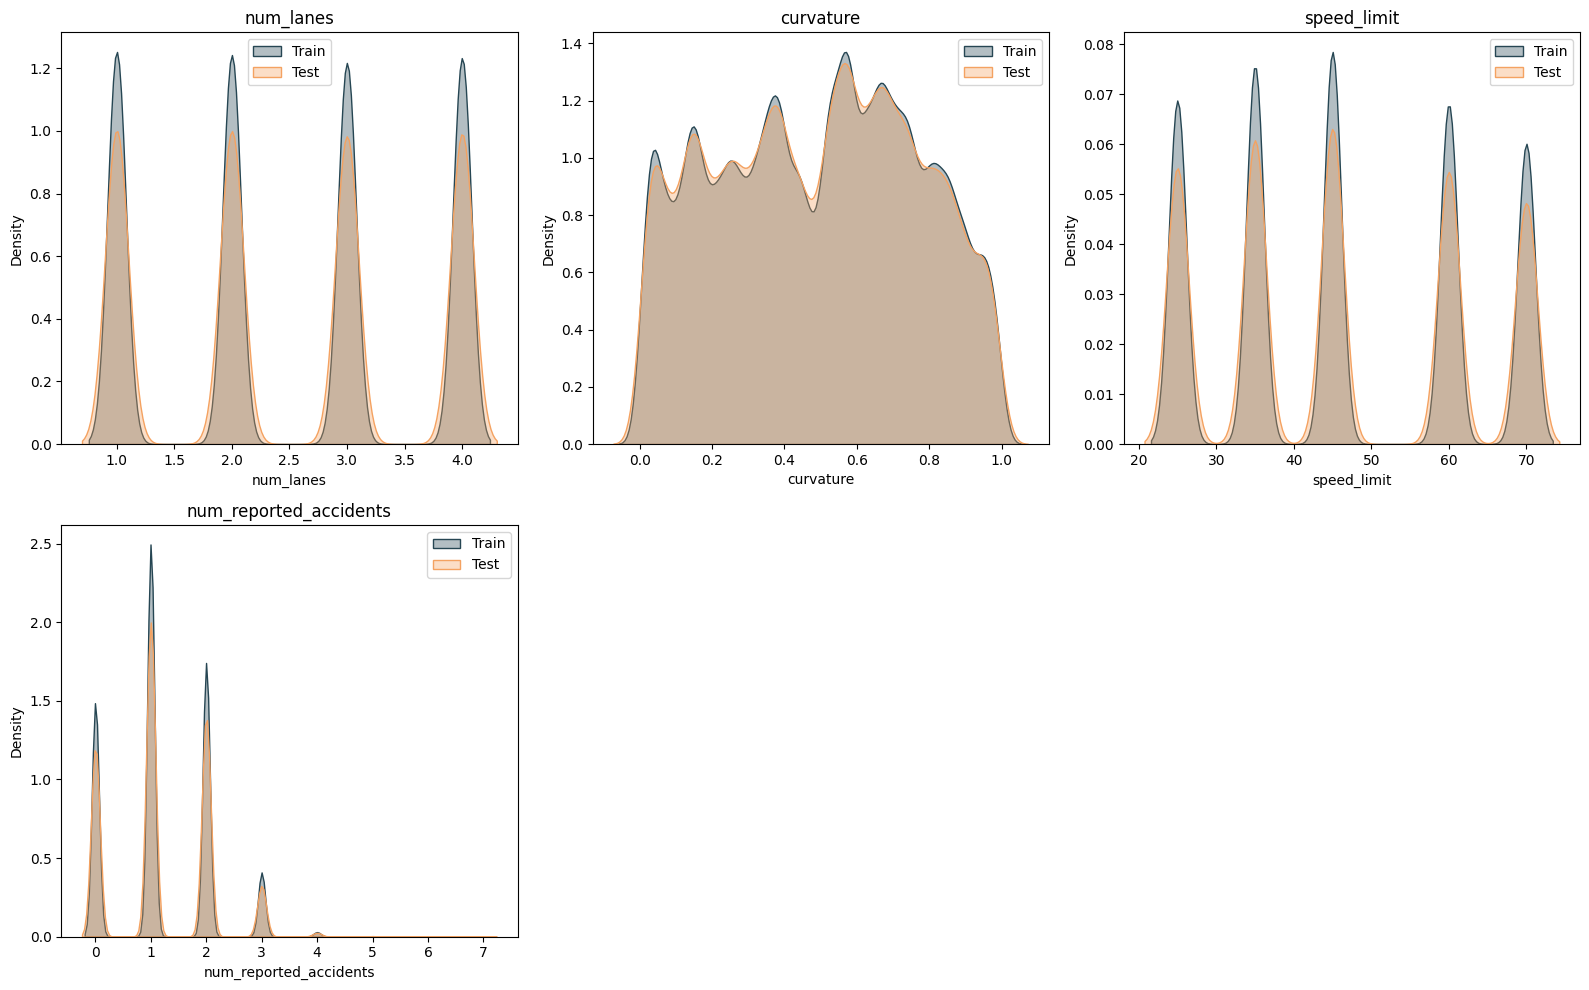

In [ ]:
print("\n\033[1m2. Numerical Features Analysis\033[0m")
print("=" * 50)

def analyze_numerical_features(
    train_data,
    test_data,
    numerical_features,
    max_features=6   # IMPORTANT: limit to avoid Colab crash
):

    if not numerical_features:
        print("No numerical features found in the dataset")
        return

    # Limit number of features
    features = numerical_features[:max_features]

    # ===============================
    # Train Data Analysis
    # ===============================
    print("\n\033[1mTrain Data Numerical Features:\033[0m")
    plt.figure(figsize=(16, 10))

    for i, feature in enumerate(features):
        plt.subplot(2, 3, i + 1)

        sns.histplot(
            train_data[feature].dropna(),
            bins=30,
            kde=True,
            color="#2a9d8f",
            edgecolor="black",
            alpha=0.85
        )

        plt.title(f"Train: {feature}")
        plt.xlabel(feature)

        stats = train_data[feature].describe()
        plt.annotate(
            f"Mean: {stats['mean']:.2f}\n"
            f"Std: {stats['std']:.2f}\n"
            f"Min: {stats['min']:.2f}\n"
            f"Max: {stats['max']:.2f}",
            xy=(0.60, 0.70),
            xycoords="axes fraction",
            bbox=dict(boxstyle="round", fc="#f1faee", ec="#457b9d")
        )

    plt.tight_layout()
    plt.show()

    # ===============================
    # Test Data Analysis
    # ===============================
    print("\n\033[1mTest Data Numerical Features:\033[0m")
    plt.figure(figsize=(16, 10))

    for i, feature in enumerate(features):
        plt.subplot(2, 3, i + 1)

        sns.histplot(
            test_data[feature].dropna(),
            bins=30,
            kde=True,
            color="#e76f51",
            edgecolor="black",
            alpha=0.85
        )

        plt.title(f"Test: {feature}")
        plt.xlabel(feature)

        stats = test_data[feature].describe()
        plt.annotate(
            f"Mean: {stats['mean']:.2f}\n"
            f"Std: {stats['std']:.2f}\n"
            f"Min: {stats['min']:.2f}\n"
            f"Max: {stats['max']:.2f}",
            xy=(0.60, 0.70),
            xycoords="axes fraction",
            bbox=dict(boxstyle="round", fc="#fefae0", ec="#e76f51")
        )

    plt.tight_layout()
    plt.show()

    # ===============================
    # Train vs Test Comparison
    # ===============================
    print("\n\033[1mTrain vs Test Comparison:\033[0m")
    plt.figure(figsize=(16, 10))

    for i, feature in enumerate(features):
        plt.subplot(2, 3, i + 1)

        sns.kdeplot(
            train_data[feature].dropna(),
            label="Train",
            color="#264653",
            fill=True,
            alpha=0.35
        )

        sns.kdeplot(
            test_data[feature].dropna(),
            label="Test",
            color="#f4a261",
            fill=True,
            alpha=0.35
        )

        plt.title(feature)
        plt.xlabel(feature)
        plt.ylabel("Density")
        plt.legend()

    plt.tight_layout()
    plt.show()


# ==================================================
# Run Numerical Feature Analysis
# ==================================================
analyze_numerical_features(
    train_df,
    test_df,
    numerical_features,
    max_features=6
)



Pairplot of Numerical Features
Features used for pairplot: ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']


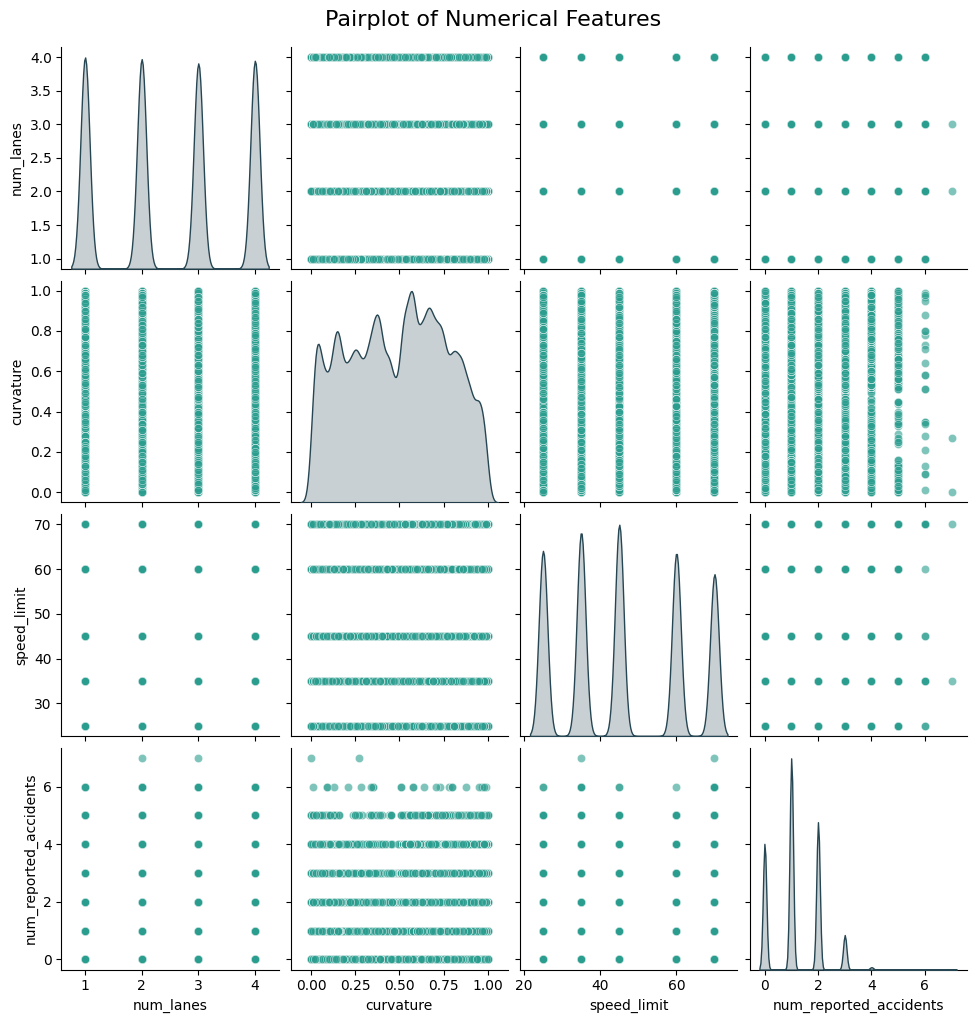

In [ ]:
# ===============================
# Pairplot of Numerical Features
# ===============================

print("\n\033[1mPairplot of Numerical Features\033[0m")
print("=" * 50)

# Select numerical features (exclude target)
numerical_features_pair = train_df.select_dtypes(include=["number"]).columns.tolist()

# Remove target safely
if "accident_risk" in numerical_features_pair:
    numerical_features_pair.remove("accident_risk")

# Optional: remove ID if present
if "id" in numerical_features_pair:
    numerical_features_pair.remove("id")

# ⚠️ VERY IMPORTANT: limit features (pairplot is expensive)
numerical_features_pair = numerical_features_pair[:5]   # keep 4–6 max

print("Features used for pairplot:", numerical_features_pair)

# Create pairplot
pairplot = sns.pairplot(
    train_df[numerical_features_pair],
    diag_kind="kde",
    plot_kws={
        "alpha": 0.6,
        "color": "#2a9d8f"   # professional teal
    },
    diag_kws={
        "color": "#264653"
    }
)

pairplot.fig.suptitle(
    "Pairplot of Numerical Features",
    y=1.02,
    fontsize=16
)

plt.show()



7. Pair Plot of Numerical Features
Numerical features used for pairplot:
['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']


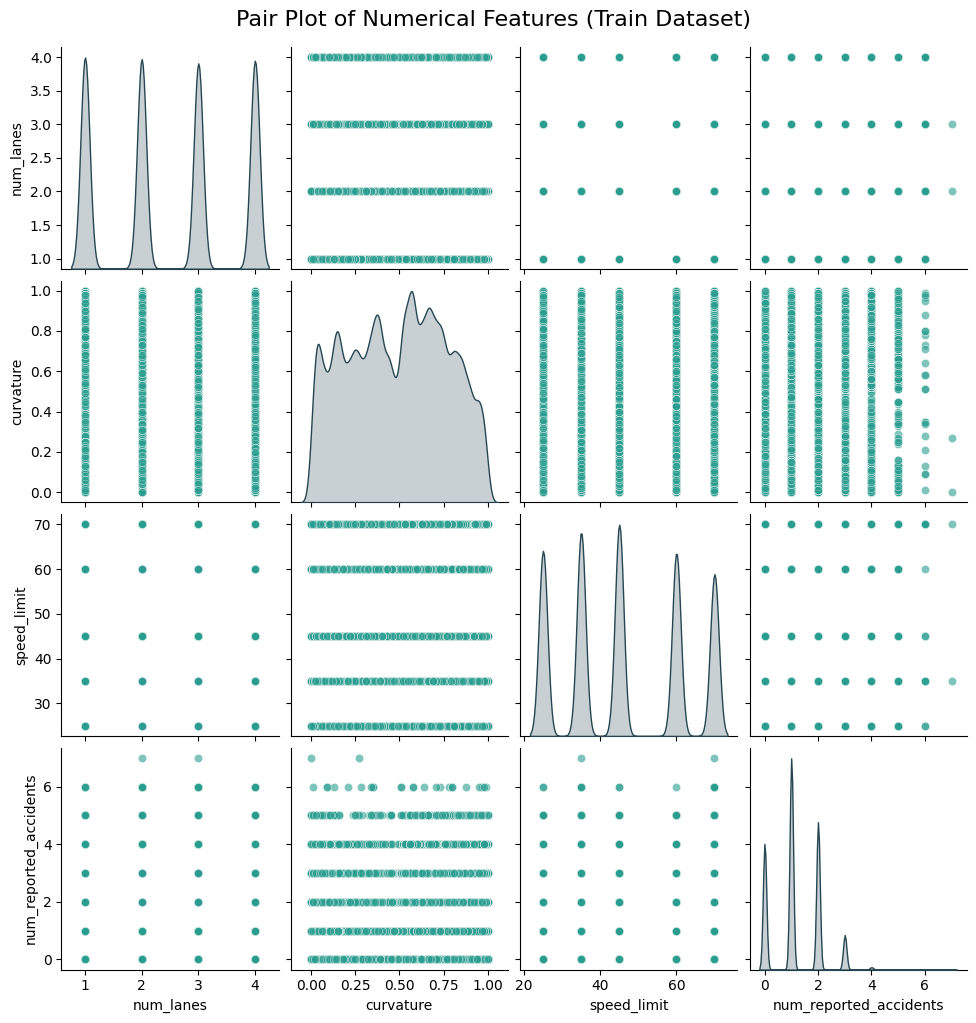

In [ ]:
# ===============================
# 7. Pair Plot of Numerical Features
# ===============================

print("\n\033[1m7. Pair Plot of Numerical Features\033[0m")
print("=" * 50)

# Select numerical features
numerical_features_pair = train_df.select_dtypes(include=["number"]).columns.tolist()

# Remove target column safely
if "accident_risk" in numerical_features_pair:
    numerical_features_pair.remove("accident_risk")

# Optional: remove ID if present
if "id" in numerical_features_pair:
    numerical_features_pair.remove("id")

# ⚠️ LIMIT features (VERY IMPORTANT)
MAX_PAIR_FEATURES = 5
numerical_features_pair = numerical_features_pair[:MAX_PAIR_FEATURES]

print("Numerical features used for pairplot:")
print(numerical_features_pair)

# Create pairplot
pairplot = sns.pairplot(
    train_df[numerical_features_pair],
    diag_kind="kde",
    plot_kws={
        "alpha": 0.6,
        "color": "#2a9d8f"   # professional teal
    },
    diag_kws={
        "color": "#264653"
    }
)

pairplot.fig.suptitle(
    "Pair Plot of Numerical Features (Train Dataset)",
    y=1.02,
    fontsize=16
)

plt.show()



6. Categorical Features Analysis

Analyzing categorical feature: road_type
--------------------------------------------------
Train unique values: 3
Test unique values : 3


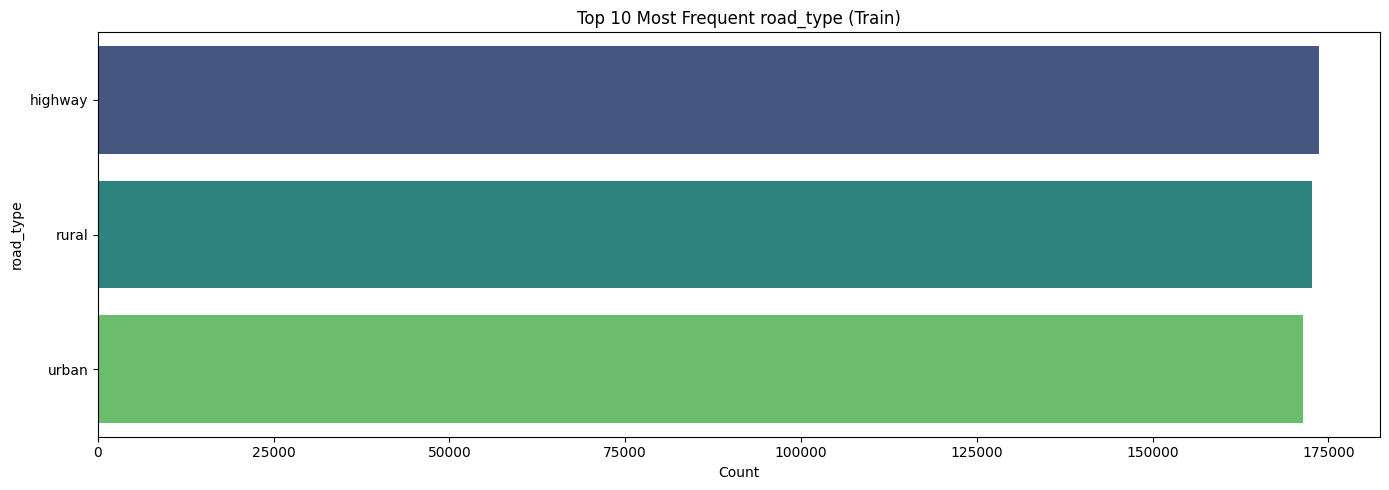


Top categories in Train:
road_type
highway    173672
rural      172719
urban      171363
Name: count, dtype: int64


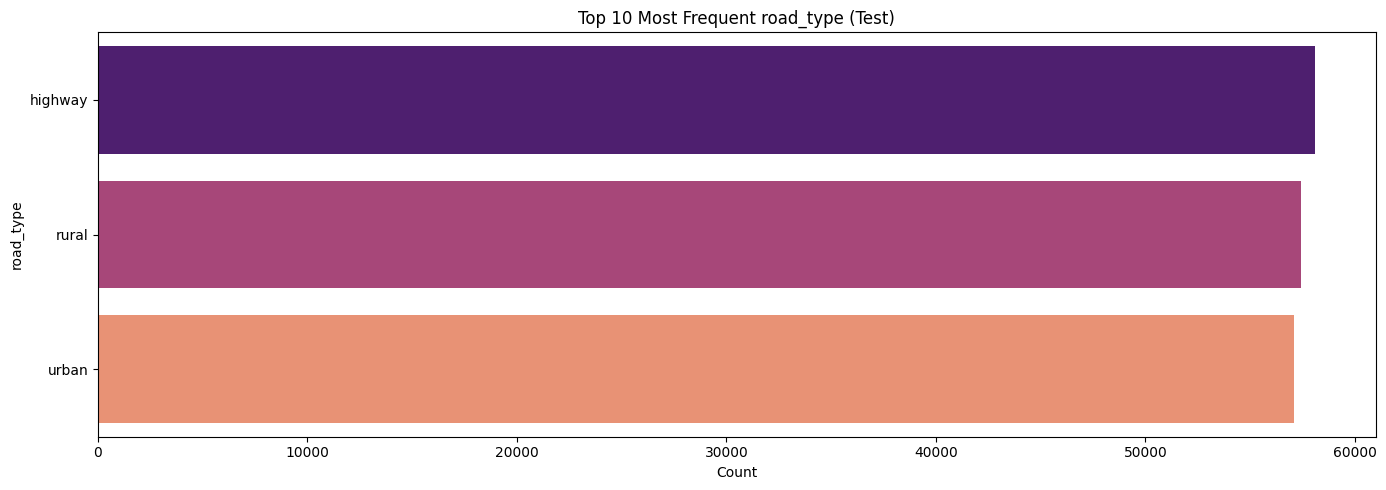


Top categories in Test:
road_type
highway    58080
rural      57409
urban      57096
Name: count, dtype: int64


Analyzing categorical feature: lighting
--------------------------------------------------
Train unique values: 3
Test unique values : 3


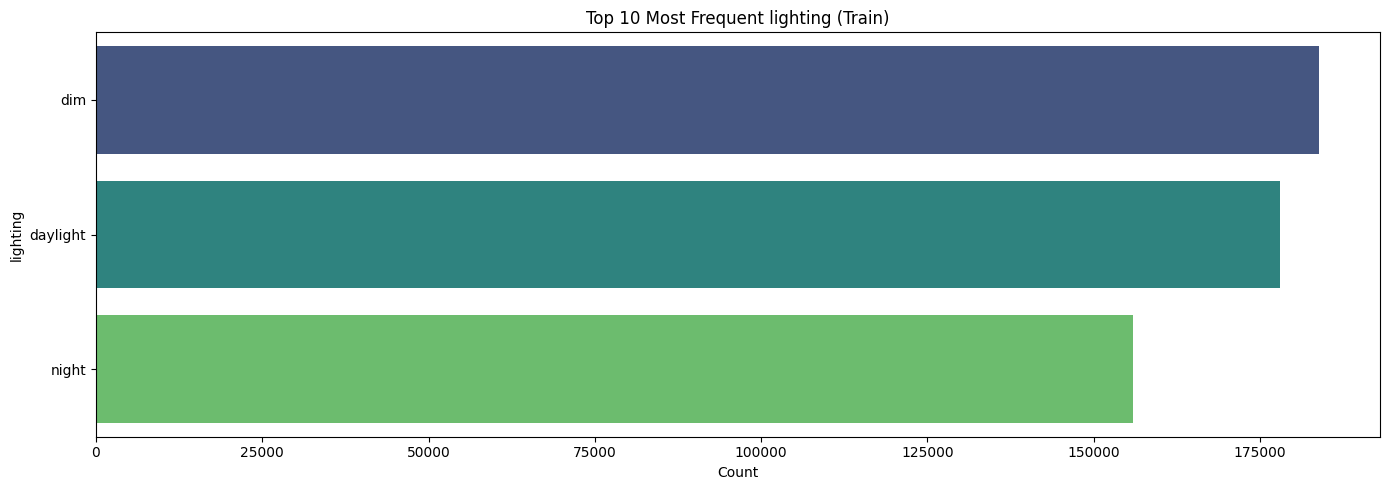


Top categories in Train:
lighting
dim         183826
daylight    178015
night       155913
Name: count, dtype: int64


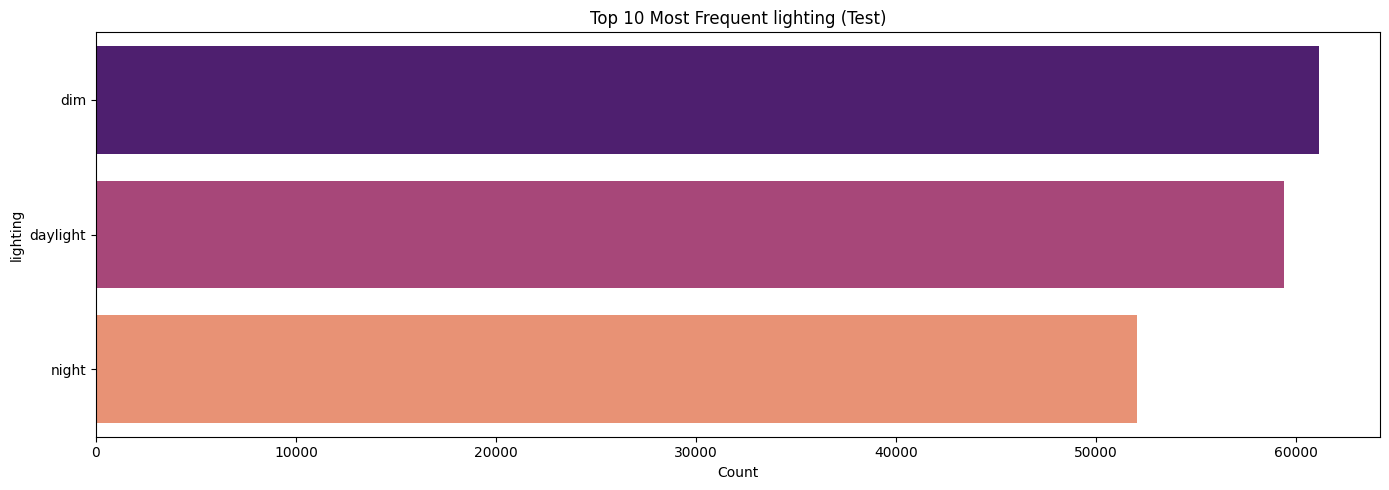


Top categories in Test:
lighting
dim         61143
daylight    59397
night       52045
Name: count, dtype: int64


Analyzing categorical feature: weather
--------------------------------------------------
Train unique values: 3
Test unique values : 3


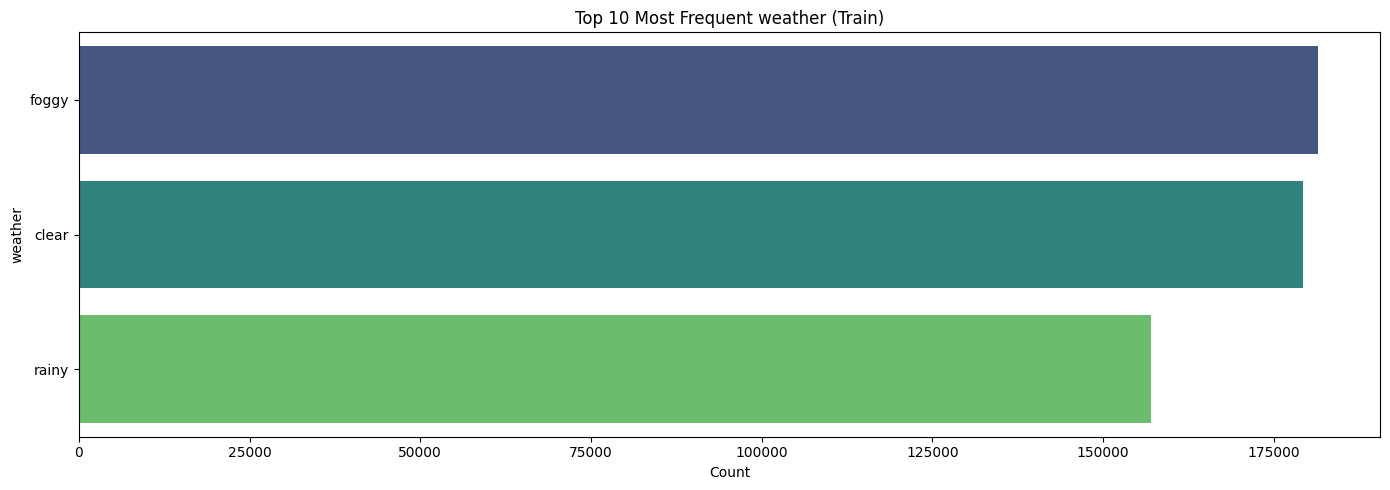


Top categories in Train:
weather
foggy    181463
clear    179306
rainy    156985
Name: count, dtype: int64


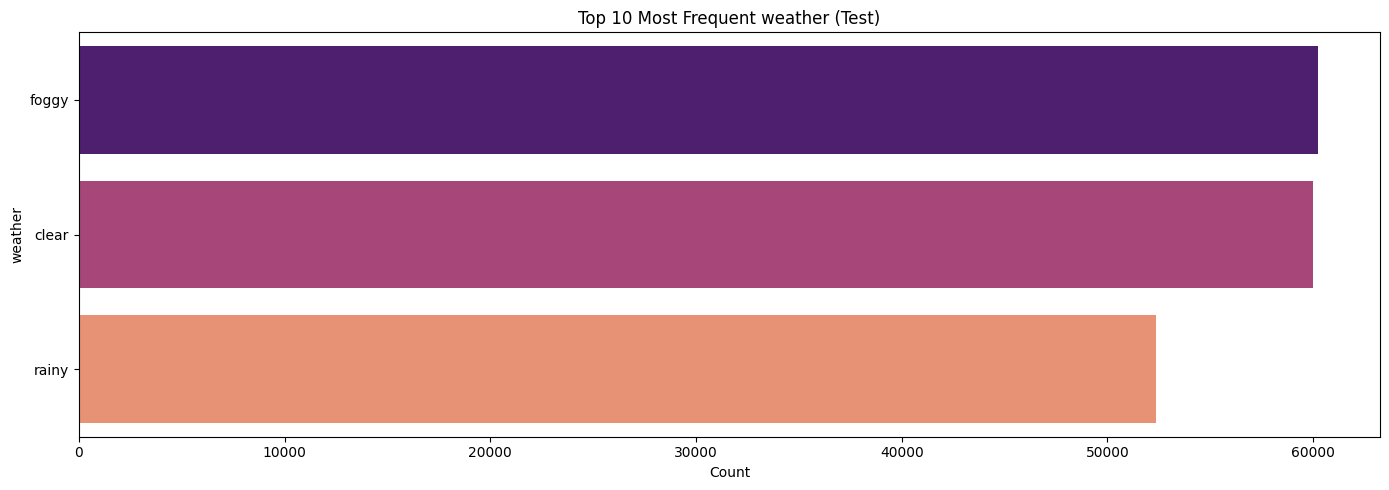


Top categories in Test:
weather
foggy    60236
clear    59982
rainy    52367
Name: count, dtype: int64


Analyzing categorical feature: time_of_day
--------------------------------------------------
Train unique values: 3
Test unique values : 3


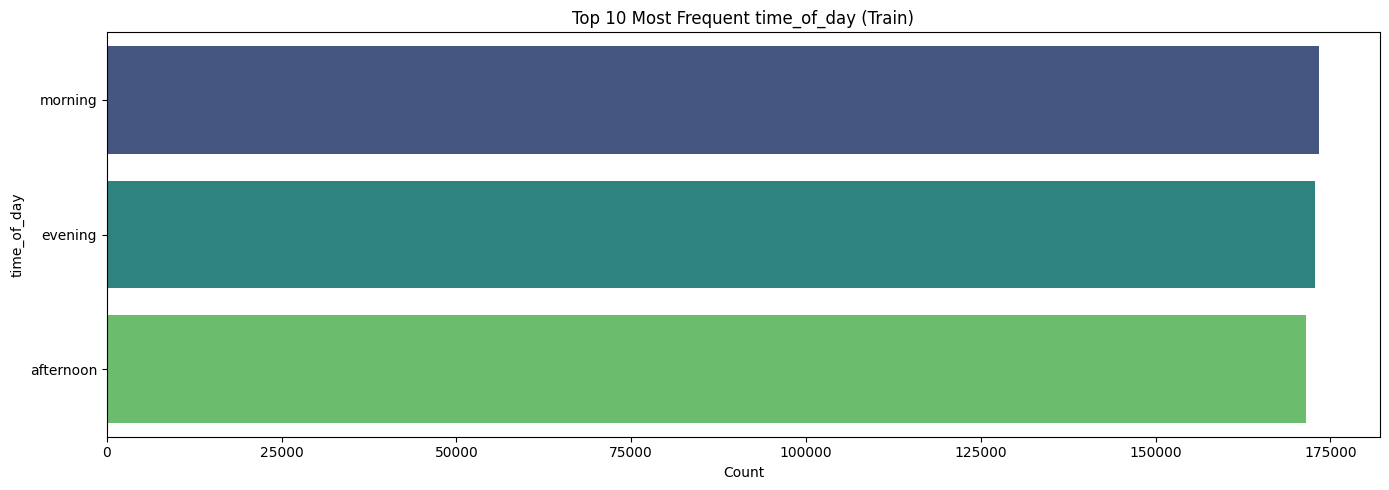


Top categories in Train:
time_of_day
morning      173410
evening      172837
afternoon    171507
Name: count, dtype: int64


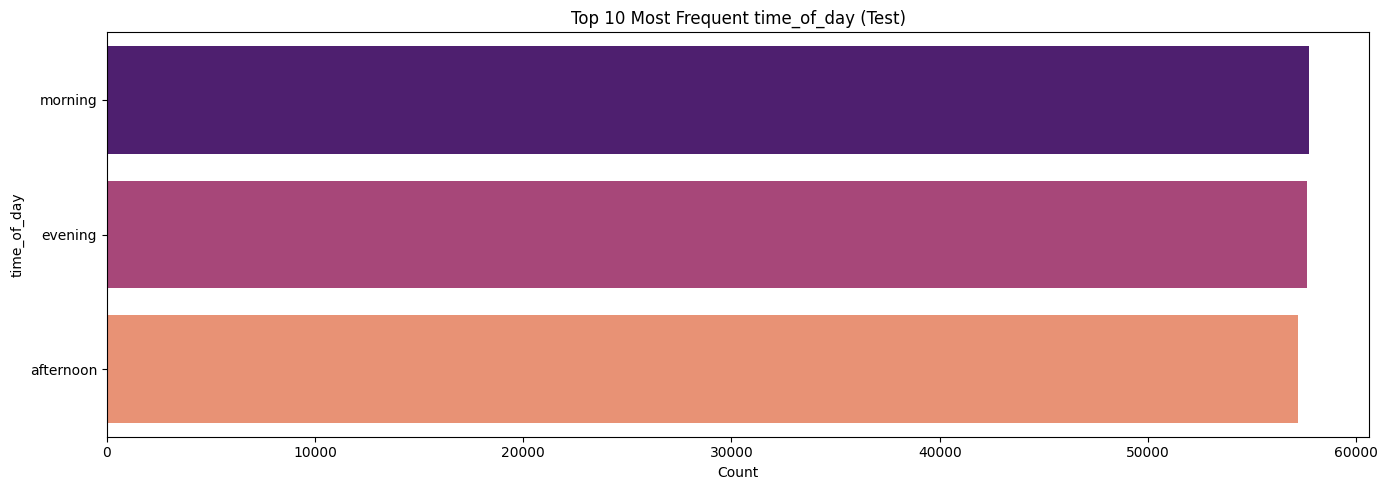


Top categories in Test:
time_of_day
morning      57747
evening      57629
afternoon    57209
Name: count, dtype: int64



In [ ]:
# ==================================================
# 6. Categorical Features Analysis
# ==================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("\n\033[1m6. Categorical Features Analysis\033[0m")
print("=" * 50)

def analyze_categorical_features(train_data, test_data, categorical_cols, top_n=10):

    if not categorical_cols:
        print("No categorical features found in the dataset")
        return

    for variable in categorical_cols:

        print(f"\nAnalyzing categorical feature: {variable}")
        print("-" * 50)

        # -----------------------------
        # Basic statistics
        # -----------------------------
        print(f"Train unique values: {train_data[variable].nunique()}")
        if variable in test_data.columns:
            print(f"Test unique values : {test_data[variable].nunique()}")

        # -----------------------------
        # Top-N most frequent categories (Train)
        # -----------------------------
        train_counts = train_data[variable].value_counts().head(top_n)

        plt.figure(figsize=(14, 5))
        sns.barplot(
            x=train_counts.values,
            y=train_counts.index,
            palette="viridis"
        )
        plt.title(f"Top {top_n} Most Frequent {variable} (Train)")
        plt.xlabel("Count")
        plt.ylabel(variable)
        plt.tight_layout()
        plt.show()

        print("\nTop categories in Train:")
        print(train_counts)

        # -----------------------------
        # Test dataset comparison
        # -----------------------------
        if variable in test_data.columns:
            test_counts = test_data[variable].value_counts().head(top_n)

            plt.figure(figsize=(14, 5))
            sns.barplot(
                x=test_counts.values,
                y=test_counts.index,
                palette="magma"
            )
            plt.title(f"Top {top_n} Most Frequent {variable} (Test)")
            plt.xlabel("Count")
            plt.ylabel(variable)
            plt.tight_layout()
            plt.show()

            print("\nTop categories in Test:")
            print(test_counts)

        print("\n" + "=" * 50)


# ==================================================
# Run Categorical Feature Analysis
# ==================================================
analyze_categorical_features(
    train_df,
    test_df,
    categorical_features,
    top_n=10
)


In [ ]:
# ==================================================
# 7. Missing Value Analysis (Train & Test)
# ==================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n\033[1m7. Missing Value Analysis\033[0m")
print("=" * 50)

def analyze_missing_values(data, title, max_heatmap_cols=30):

    # -----------------------------
    # Count missing values
    # -----------------------------
    missing = data.isnull().sum()
    missing = missing[missing > 0]

    if len(missing) == 0:
        print(f"\n✅ No missing values found in {title} dataset!")
        return None

    missing_percent = (missing / len(data)) * 100

    # Limit heatmap columns for performance
    heatmap_cols = missing.index[:max_heatmap_cols]

    plt.figure(figsize=(18, 6))
    plt.suptitle(f"Missing Value Analysis: {title} Dataset", y=1.05, fontsize=14)

    # -----------------------------
    # Heatmap (only missing columns)
    # -----------------------------
    plt.subplot(1, 3, 1)
    sns.heatmap(
        data[heatmap_cols].isnull(),
        cmap="viridis",
        cbar=False,
        yticklabels=False
    )
    plt.title("Missing Value Pattern")
    plt.xlabel("Features")

    # -----------------------------
    # Bar Plot
    # -----------------------------
    plt.subplot(1, 3, 2)
    bars = sns.barplot(
        x=missing.values,
        y=missing.index,
        palette="viridis"
    )
    plt.title("Missing Value Count")
    plt.xlabel("Count")

    for i, (count, percent) in enumerate(zip(missing.values, missing_percent)):
        bars.text(
            count + max(missing.values) * 0.02,
            i,
            f"{count:,} ({percent:.2f}%)",
            va="center",
            fontsize=9
        )

    # -----------------------------
    # Pie Chart
    # -----------------------------
    plt.subplot(1, 3, 3)
    plt.pie(
        missing.values,
        labels=missing.index,
        autopct="%1.1f%%",
        startangle=90,
        colors=sns.color_palette("viridis"),
        wedgeprops={"edgecolor": "white"}
    )
    plt.title("Missing Value Distribution")

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Detailed Statistics Table
    # -----------------------------
    stats_df = pd.DataFrame({
        "Missing Count": missing,
        "Missing (%)": missing_percent.round(2),
        "Data Type": data[missing.index].dtypes
    }).sort_values("Missing Count", ascending=False)

    print(f"\nDetailed Missing Value Statistics ({title} Dataset):")
    display(stats_df.style.format({"Missing (%)": "{:.2f}%"}))

    return stats_df


# ==================================================
# Run Analysis for Train & Test
# ==================================================
print("\nTrain Dataset Missing Values:")
train_missing = analyze_missing_values(train_df, "Train")

print("\nTest Dataset Missing Values:")
test_missing = analyze_missing_values(test_df, "Test")

# ==================================================
# Comparative Summary
# ==================================================
print("\nMissing Data Summary Comparison")
print("-" * 45)
print(f"{'Metric':<30} {'Train':<10} {'Test':<10}")
print(f"{'Total missing values':<30} "
      f"{train_df.isnull().sum().sum():<10,} "
      f"{test_df.isnull().sum().sum():<10,}")
print(f"{'Columns with missing values':<30} "
      f"{len(train_missing) if train_missing is not None else 0:<10} "
      f"{len(test_missing) if test_missing is not None else 0:<10}")



7. Missing Value Analysis

Train Dataset Missing Values:

✅ No missing values found in Train dataset!

Test Dataset Missing Values:

✅ No missing values found in Test dataset!

Missing Data Summary Comparison
---------------------------------------------
Metric                         Train      Test      
Total missing values           0          0         
Columns with missing values    0          0         



8. Outlier Analysis

Train Data Outliers:


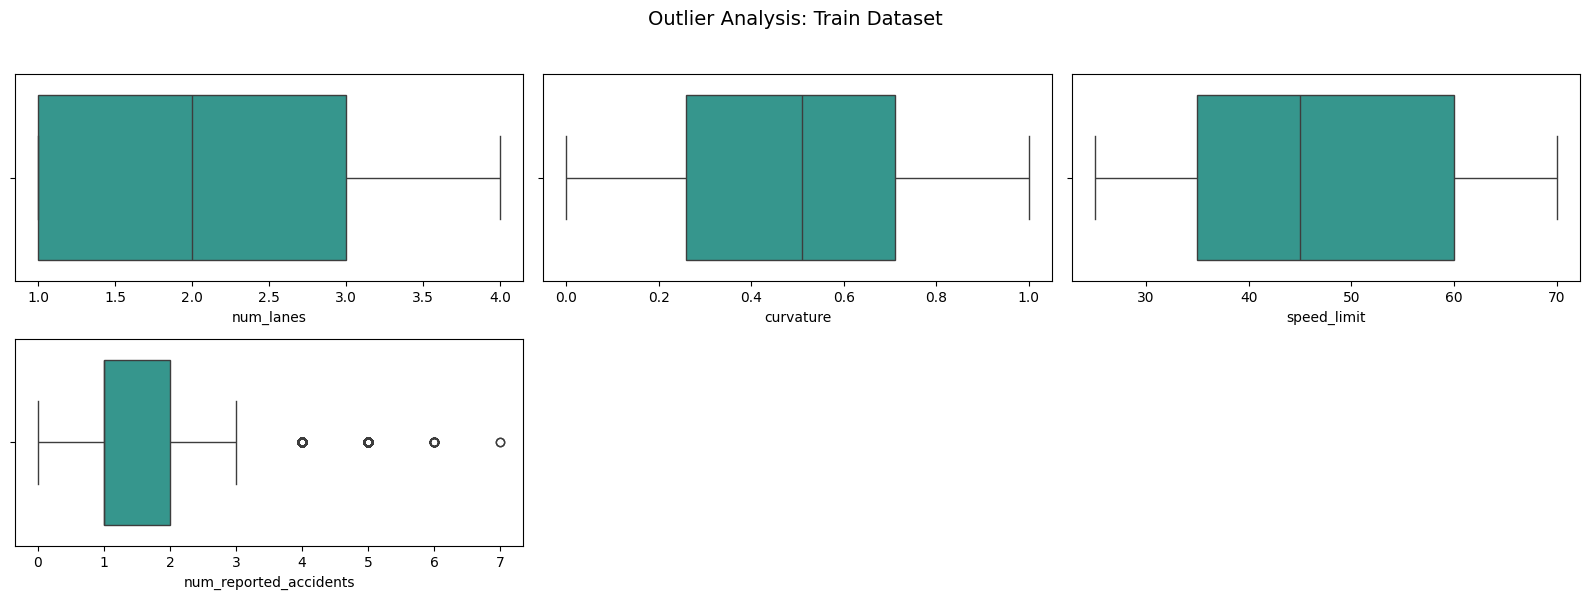


Test Data Outliers:


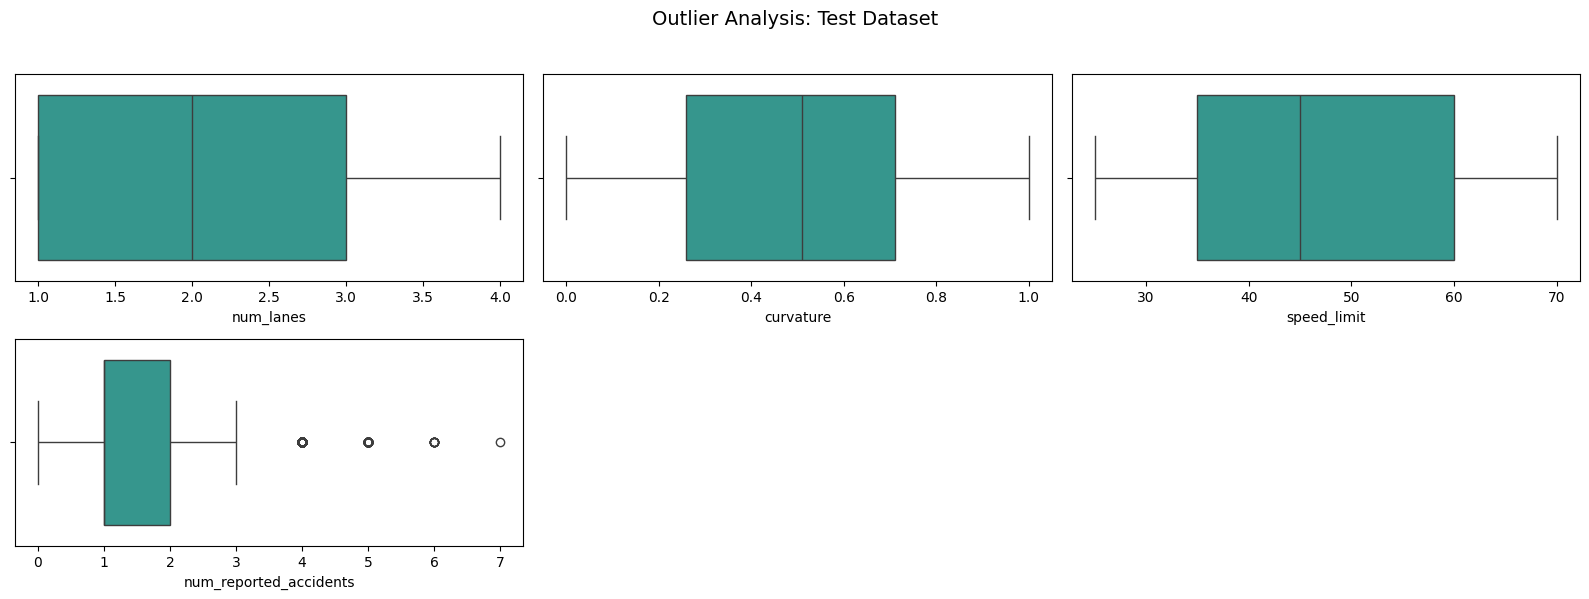

In [ ]:
# ==================================================
# 8. Outlier Analysis (Train & Test)
# ==================================================

print("\n\033[1m8. Outlier Analysis\033[0m")
print("=" * 50)

def analyze_outliers(train_data, test_data, numerical_features, max_features=9):
    """
    Boxplot-based outlier analysis for numerical features.
    Limited to max_features to avoid Colab rendering issues.
    """

    if not numerical_features:
        print("No numerical features available for outlier analysis.")
        return

    # Limit number of features
    features = numerical_features[:max_features]

    # ===============================
    # Train Data Outliers
    # ===============================
    print("\nTrain Data Outliers:")
    plt.figure(figsize=(16, 8))
    plt.suptitle("Outlier Analysis: Train Dataset", y=1.02, fontsize=14)

    for i, feature in enumerate(features):
        plt.subplot(3, 3, i + 1)
        sns.boxplot(
            x=train_data[feature].dropna(),
            color="#26A69A",
            showfliers=True
        )
        plt.xlabel(feature)

    plt.tight_layout()
    plt.show()

    # ===============================
    # Test Data Outliers
    # ===============================
    print("\nTest Data Outliers:")
    plt.figure(figsize=(16, 8))
    plt.suptitle("Outlier Analysis: Test Dataset", y=1.02, fontsize=14)

    for i, feature in enumerate(features):
        plt.subplot(3, 3, i + 1)
        sns.boxplot(
            x=test_data[feature].dropna(),
            color="#26A69A",
            showfliers=True
        )
        plt.xlabel(feature)

    plt.tight_layout()
    plt.show()


# ==================================================
# Run Outlier Analysis
# ==================================================
analyze_outliers(
    train_df,
    test_df,
    numerical_features,
    max_features=9
)



9. Correlation Analysis

Train Data Correlation Analysis:


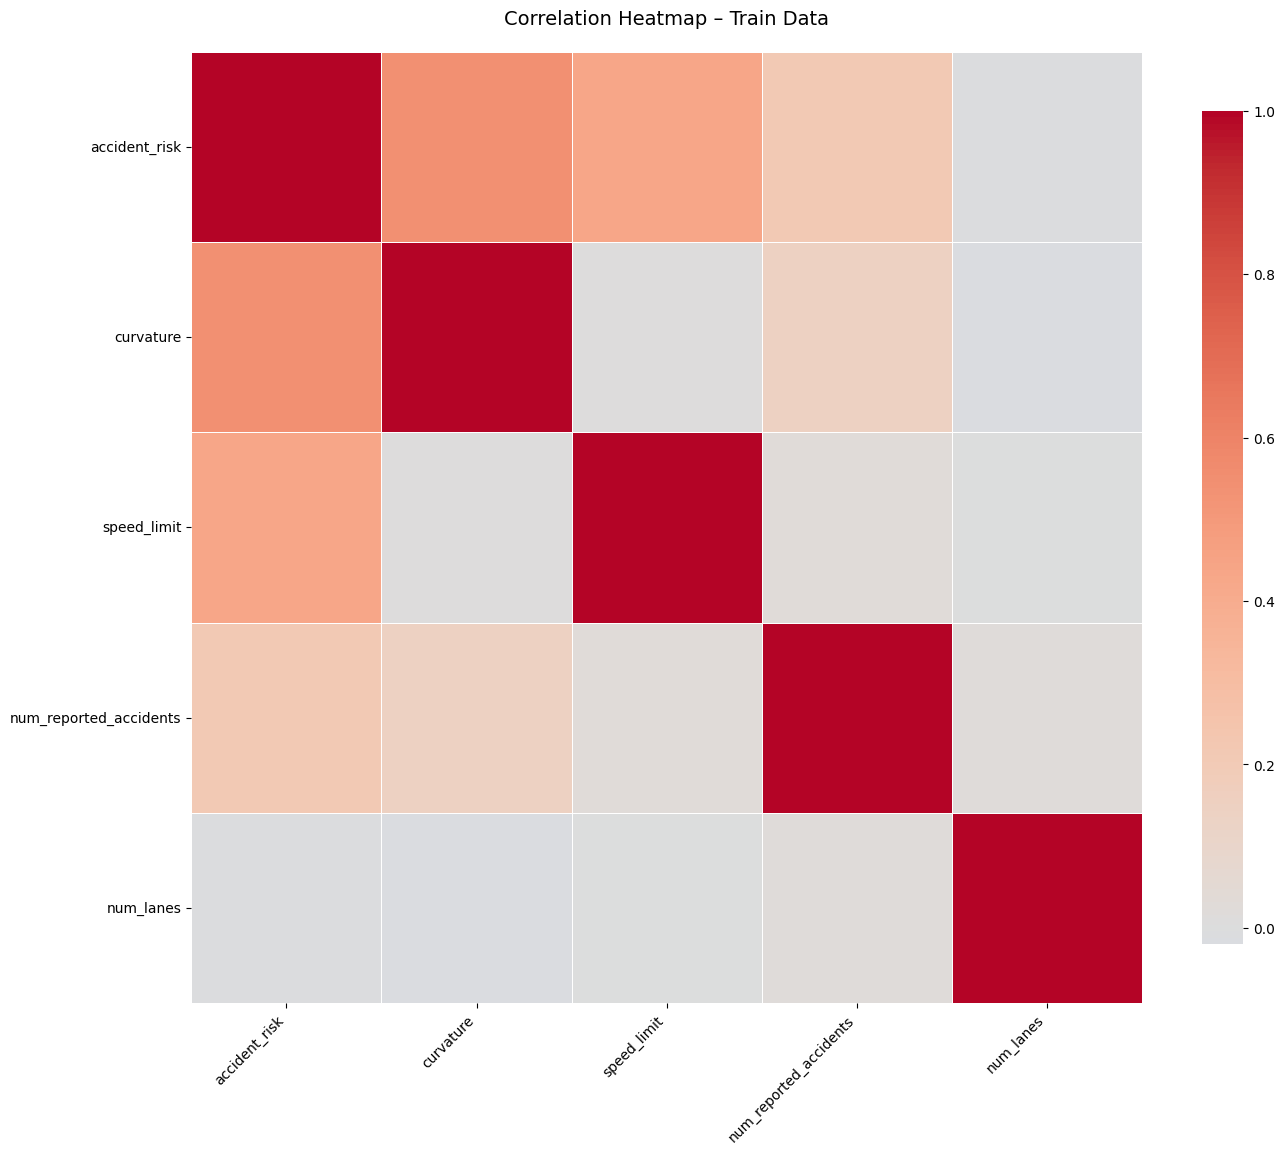


Top correlations with target (accident_risk):


,Correlation
accident_risk,1.000000
curvature,0.543946
speed_limit,0.430898
num_reported_accidents,0.213891
num_lanes,-0.006003



Test Data Correlation Analysis:


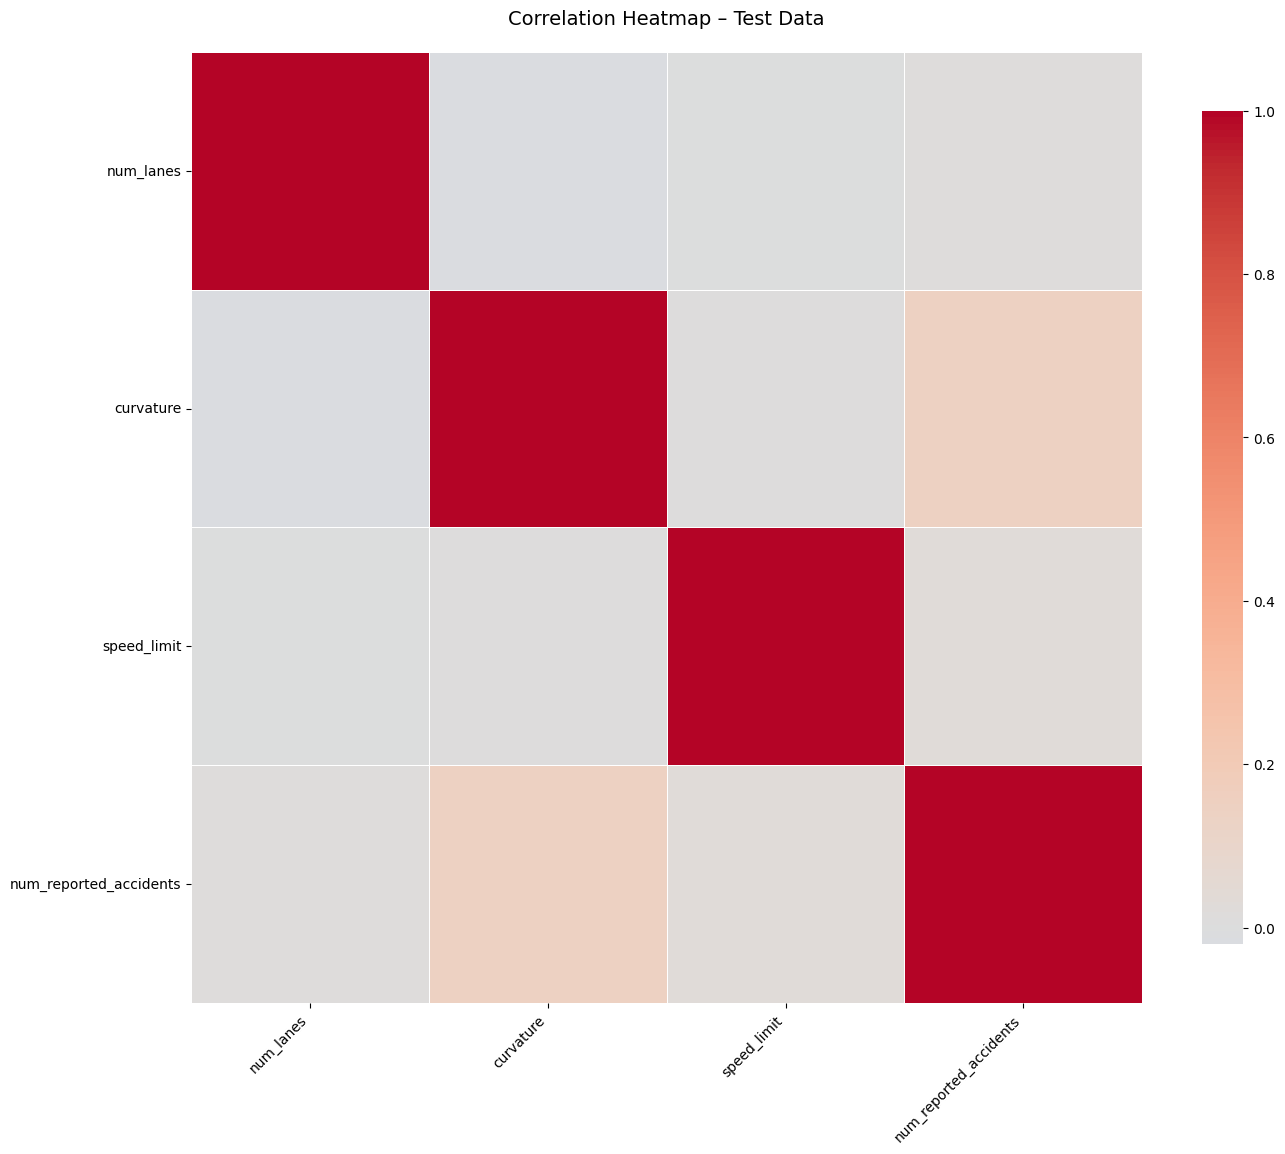

In [ ]:
# ==================================================
# 9. Correlation Analysis
# ==================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n\033[1m9. Correlation Analysis\033[0m")
print("=" * 50)

def plot_correlation_matrix(
    data,
    title,
    target_col=None,
    max_features=20   # IMPORTANT: limit for performance
):
    """
    Plots correlation heatmap for numerical features.
    Also shows target correlation ranking if target_col is provided.
    """

    # Select numerical data
    numerical_data = data.select_dtypes(include=np.number)

    if numerical_data.shape[1] < 2:
        print("Not enough numerical features for correlation analysis.")
        return

    # -----------------------------
    # Reduce features for heatmap
    # -----------------------------
    if target_col and target_col in numerical_data.columns:
        # Use features most correlated with target
        corr_target = numerical_data.corr()[target_col].abs()
        selected_features = (
            corr_target
            .sort_values(ascending=False)
            .head(max_features)
            .index
        )
        corr_data = numerical_data[selected_features]
    else:
        corr_data = numerical_data.iloc[:, :max_features]

    # -----------------------------
    # Correlation heatmap
    # -----------------------------
    corr_matrix = corr_data.corr()

    plt.figure(figsize=(14, 12))
    sns.heatmap(
        corr_matrix,
        cmap="coolwarm",
        center=0,
        square=True,
        cbar_kws={"shrink": 0.8},
        linewidths=0.5
    )
    plt.title(f"Correlation Heatmap – {title}", fontsize=14, pad=20)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Target correlation ranking
    # -----------------------------
    if target_col and target_col in numerical_data.columns:
        print(f"\nTop correlations with target ({target_col}):")
        target_corr = (
            numerical_data.corr()[target_col]
            .sort_values(ascending=False)
        )
        display(
            target_corr.to_frame("Correlation")
            .style.background_gradient(cmap="coolwarm")
        )


# ==================================================
# Run Correlation Analysis
# ==================================================

print("\nTrain Data Correlation Analysis:")
plot_correlation_matrix(
    train_df,
    title="Train Data",
    target_col="accident_risk",
    max_features=20
)

print("\nTest Data Correlation Analysis:")
plot_correlation_matrix(
    test_df,
    title="Test Data",
    target_col=None,
    max_features=20
)


In [ ]:
# ==================================================
# 10. Remove Unnecessary Columns & Define Features
# ==================================================

print("\n\033[1m10. Remove Unnecessary Columns\033[0m")
print("=" * 50)

# ===============================
# Preserve Test IDs (for submission)
# ===============================
if "id" in test_df.columns:
    test_ids = test_df["id"].copy()
    print("✅ Test IDs stored for submission")
else:
    test_ids = None
    print("⚠️ 'id' column not found in test_df")

# ===============================
# Drop ID column safely
# ===============================
if "id" in train_df.columns:
    train_df.drop(columns=["id"], inplace=True)

if "id" in test_df.columns:
    test_df.drop(columns=["id"], inplace=True)

# ===============================
# Define Target Variable
# ===============================
target = "accident_risk"

# ===============================
# Remove Non-Model Columns (if any)
# ===============================
# Keep this safe check even if column does not exist
if "SMILES" in train_df.columns:
    train_df.drop(columns=["SMILES"], inplace=True)

if "SMILES" in test_df.columns:
    test_df.drop(columns=["SMILES"], inplace=True)

# ===============================
# Define Feature Columns Automatically
# ===============================
numerical_features = train_df.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()

# Remove target from numerical features
if target in numerical_features:
    numerical_features.remove(target)

categorical_features = train_df.select_dtypes(
    include=["object"]
).columns.tolist()

# ===============================
# Quick Validation
# ===============================
print("\nTarget Variable:", target)
print("\nNumber of Numerical Features:", len(numerical_features))
print("Sample Numerical Features:", numerical_features[:5])
print("\nNumber of Categorical Features:", len(categorical_features))
print("Categorical Features:", categorical_features)

print("\nFinal Train Shape:", train_df.shape)
print("Final Test Shape :", test_df.shape)



10. Remove Unnecessary Columns
⚠️ 'id' column not found in test_df

Target Variable: accident_risk

Number of Numerical Features: 4
Sample Numerical Features: ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

Number of Categorical Features: 4
Categorical Features: ['road_type', 'lighting', 'weather', 'time_of_day']

Final Train Shape: (517754, 13)
Final Test Shape : (172585, 12)


In [ ]:
# ==================================================
# 11. Handle Missing Values (Accident Risk Dataset)
# ==================================================

import pandas as pd
from sklearn.impute import SimpleImputer

print("\n" + "=" * 50)
print("Handle Missing Values (Numerical Features)")
print("=" * 50)

# ===============================
# Target Variable
# ===============================
target = "accident_risk"

# ===============================
# Separate Features & Target
# ===============================
X_train = train_df.drop(columns=[target], errors="ignore")
y_train = train_df[target]

X_test = test_df.copy()

# ===============================
# Identify Numerical Features
# ===============================
numerical_features = X_train.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()

print(f"\nNumber of numerical features: {len(numerical_features)}")

# ===============================
# Check Missing Values (Before)
# ===============================
print("\nMissing values in TRAIN (before imputation):")
print(X_train[numerical_features].isnull().sum().sum())

print("\nMissing values in TEST (before imputation):")
print(X_test[numerical_features].isnull().sum().sum())

# ===============================
# Impute Missing Values (Median)
# ===============================
num_imputer = SimpleImputer(strategy="median")

X_train[numerical_features] = num_imputer.fit_transform(
    X_train[numerical_features]
)

X_test[numerical_features] = num_imputer.transform(
    X_test[numerical_features]
)

# ===============================
# Verify Missing Values Removed
# ===============================
print("\nMissing values in TRAIN (after imputation):")
print(X_train.isnull().sum().sum())

print("\nMissing values in TEST (after imputation):")
print(X_test.isnull().sum().sum())

# ===============================
# Final Dataset Shapes
# ===============================
print("\nFinal Dataset Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test :", X_test.shape)

print("\n✅ Missing value handling completed successfully")



Handle Missing Values (Numerical Features)

Number of numerical features: 4

Missing values in TRAIN (before imputation):
0

Missing values in TEST (before imputation):
0

Missing values in TRAIN (after imputation):
0

Missing values in TEST (after imputation):
0

Final Dataset Shapes:
X_train: (517754, 12)
y_train: (517754,)
X_test : (172585, 12)

✅ Missing value handling completed successfully



Target Distribution Analysis (Accident Risk)


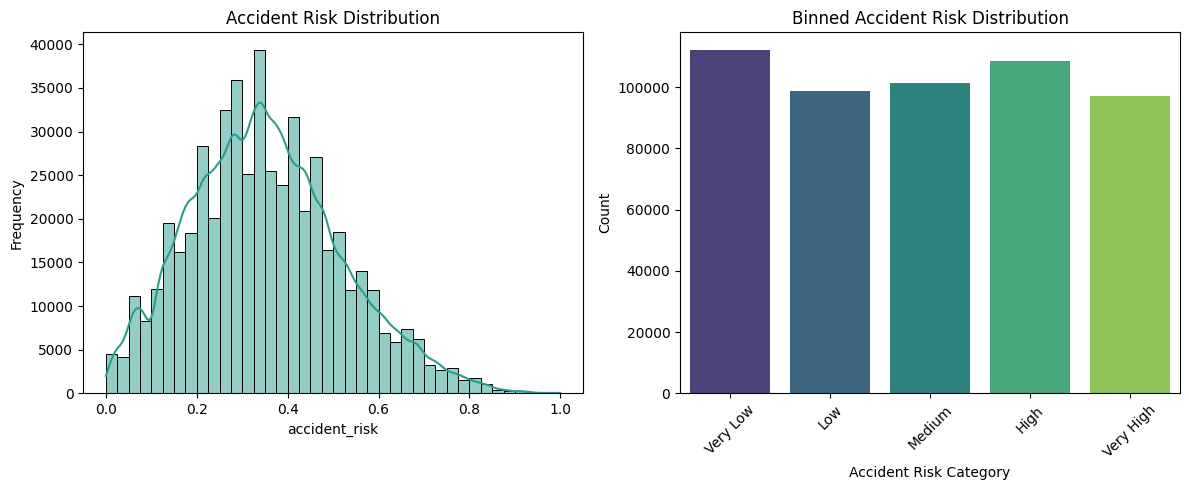


✅ Target distribution analysis completed


In [ ]:
# ==================================================
# 12. Target Distribution Analysis (Regression)
# ==================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("\n" + "=" * 50)
print("Target Distribution Analysis (Accident Risk)")
print("=" * 50)

target = "accident_risk"

# ===============================
# Visualize Target Distribution
# ===============================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(
    train_df[target],
    bins=40,
    kde=True,
    color="#2a9d8f"
)
plt.title("Accident Risk Distribution")
plt.xlabel("accident_risk")
plt.ylabel("Frequency")

# ===============================
# Binned Target Distribution (Visualization Only)
# ===============================
train_df["accident_risk_bin"] = pd.qcut(
    train_df[target],
    q=5,
    labels=["Very Low", "Low", "Medium", "High", "Very High"]
)

plt.subplot(1, 2, 2)
sns.countplot(
    x=train_df["accident_risk_bin"],
    palette="viridis"
)
plt.title("Binned Accident Risk Distribution")
plt.xlabel("Accident Risk Category")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# ===============================
# Clean up helper column
# ===============================
train_df.drop(columns=["accident_risk_bin"], inplace=True)

print("\n✅ Target distribution analysis completed")


In [ ]:
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

print("\n" + "=" * 60)
print("MODEL SELECTION WITH TUNED BASE PARAMETERS")
print("=" * 60)

# ==================================================
# CLEAN DATA BEFORE MODELING
# ==================================================

# Remove any leftover EDA helper columns
eda_helper_cols = ["accident_risk_bin"]

for col in eda_helper_cols:
    if col in train_df.columns:
        train_df.drop(columns=[col], inplace=True)
        print(f"Removed EDA helper column: {col}")

# ==================================================
# PREPARE FEATURES & TARGET
# ==================================================

target = "accident_risk"

X = train_df.drop(columns=[target])
y = train_df[target]

print("\nFeature matrix shape:", X.shape)
print("Target shape:", y.shape)

# Identify categorical and numerical features for preprocessing
numerical_features = X.select_dtypes(include=['int64', 'float64', 'bool']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print("\nNumerical features for preprocessing:", numerical_features.tolist())
print("Categorical features for preprocessing:", categorical_features.tolist())

# ==================================================
# PREPROCESSING PIPELINE
# ==================================================

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any, though none are expected
)

# ==================================================
# DEFINE MODELS WITH GOOD BASE PARAMETERS (WITH PREPROCESSOR)
# ==================================================

models = {
    "RandomForest": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=100, # Reduced n_estimators to save memory
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=42,
            n_jobs=-1
        ))
    ]),

    "XGBoost": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        ))
    ]),

    "CatBoost": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', CatBoostRegressor(
            iterations=500,
            learning_rate=0.05,
            depth=6,
            loss_function="RMSE",
            random_seed=42,
            verbose=0,
            # CatBoost can handle categorical features directly, but for consistency
            # with the ColumnTransformer approach, we'll let the OneHotEncoder handle it.
            # Alternatively, one could pass cat_features=categorical_features to CatBoostRegressor
            # and remove 'cat' transformer from preprocessor for CatBoost only.
            # For this example, we keep preprocessing uniform.
        ))
    ])
}

# ==================================================
# CROSS-VALIDATION SETUP
# ==================================================

cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# ==================================================
# EVALUATE MODELS (RMSE)
# ==================================================

model_results = {}

for name, model in models.items():

    print(f"\nEvaluating {name}...")
    scores = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=1 # Changed n_jobs from -1 to 1 to avoid resource issues
    )

    rmse_scores = -scores

    model_results[name] = {
        "mean_rmse": rmse_scores.mean(),
        "std_rmse": rmse_scores.std(),
        "scores": rmse_scores
    }

    print(f"\n{name}")
    print("-" * 40)
    print("CV RMSE Scores :", np.round(rmse_scores, 4))
    print(f"Mean RMSE     : {rmse_scores.mean():.4f}")
    print(f"Std Deviation : {rmse_scores.std():.4f}")

# ==================================================
# SELECT BEST MODEL
# ==================================================

best_model_name = min(
    model_results,
    key=lambda x: model_results[x]["mean_rmse"]
)

best_model_score = model_results[best_model_name]["mean_rmse"]

print("\n" + "=" * 60)
print(f"SELECTED BEST MODEL : {best_model_name}")
print(f"BEST CV RMSE       : {best_model_score:.4f}")
print("=" * 60)


MODEL SELECTION WITH TUNED BASE PARAMETERS

Feature matrix shape: (517754, 12)
Target shape: (517754,)

Numerical features for preprocessing: ['num_lanes', 'curvature', 'speed_limit', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'num_reported_accidents']
Categorical features for preprocessing: ['road_type', 'lighting', 'weather', 'time_of_day']

Evaluating RandomForest...

RandomForest
----------------------------------------
CV RMSE Scores : [0.0594 0.0594 0.0595 0.0592 0.0591]
Mean RMSE     : 0.0593
Std Deviation : 0.0001

Evaluating XGBoost...

XGBoost
----------------------------------------
CV RMSE Scores : [0.0562 0.0561 0.0561 0.056  0.0559]
Mean RMSE     : 0.0561
Std Deviation : 0.0001

Evaluating CatBoost...

CatBoost
----------------------------------------
CV RMSE Scores : [0.0564 0.0562 0.0563 0.0562 0.0561]
Mean RMSE     : 0.0562
Std Deviation : 0.0001

SELECTED BEST MODEL : XGBoost
BEST CV RMSE       : 0.0561


In [ ]:
import optuna
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

print("\n" + "=" * 60)
print(f"HYPERPARAMETER TUNING FOR {best_model_name}")
print("=" * 60)

# ==================================================
# Cross-validation setup
# ==================================================
cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# ==================================================
# Re-define preprocessor for Optuna (ensure accessibility)
# It's good practice to re-define or pass it if the objective is run in a separate context
# Re-using numerical_features and categorical_features from previous cell
# PREPARE FEATURES & TARGET
target = "accident_risk"

X = train_df.drop(columns=[target])
y = train_df[target]

numerical_features = X.select_dtypes(include=['int64', 'float64', 'bool']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# ==================================================
# Optuna Objective Function
# ==================================================
def objective(trial):

    if best_model_name == "XGBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 300, 800),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 1),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
            "objective": "reg:squarederror",
            "random_state": 42,
            "n_jobs": -1
        }
        # Wrap XGBRegressor in a Pipeline with the preprocessor
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', XGBRegressor(**params))
        ])

    elif best_model_name == "RandomForest":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 300, 800),
            "max_depth": trial.suggest_int("max_depth", 5, 30),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
            "random_state": 42,
            "n_jobs": -1
        }
        # RandomForest already handled by preprocessor in `models` dict, here we need to include it too
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(**params))
        ])

    elif best_model_name == "CatBoost":
        params = {
            "iterations": trial.suggest_int("iterations", 300, 800),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
            "random_strength": trial.suggest_float("random_strength", 0, 1),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
            "loss_function": "RMSE",
            "random_seed": 42,
            "verbose": 0
        }
        # CatBoost already handled by preprocessor in `models` dict, here we need to include it too
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', CatBoostRegressor(**params))
        ])

    else:
        raise ValueError("Unsupported model for hyperparameter tuning")

    # ------------------------------
    # Evaluate using RMSE
    # ------------------------------
    scores = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=1 # Changed n_jobs to 1 to avoid resource issues and potential deadlocks during CV within Optuna
    )

    rmse = -scores.mean()
    return rmse


# ==================================================
# Run Optuna Study
# ==================================================
study = optuna.create_study(direction="minimize")
study.optimize(
    objective,
    n_trials=30,      # increase to 50–100 for final submission
    timeout=3600
)

# ==================================================
# Display Best Results
# ==================================================
print("\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

print(f"\nBest CV RMSE after tuning: {study.best_value:.4f}")

[I 2026-01-18 17:10:43,629] A new study created in memory with name: no-name-47e5d73f-6f86-4a6e-b805-bff5f114639f



HYPERPARAMETER TUNING FOR XGBoost


[I 2026-01-18 17:11:18,356] Trial 0 finished with value: 0.05668610491023189 and parameters: {'n_estimators': 359, 'max_depth': 5, 'learning_rate': 0.1757523754786363, 'subsample': 0.7450395690325095, 'colsample_bytree': 0.8522620494199259, 'gamma': 0.36520966242239083, 'reg_alpha': 1.2861810119620203, 'reg_lambda': 4.72290863319972}. Best is trial 0 with value: 0.05668610491023189.
[I 2026-01-18 17:12:01,299] Trial 1 finished with value: 0.056567831933565516 and parameters: {'n_estimators': 308, 'max_depth': 10, 'learning_rate': 0.0544070416353757, 'subsample': 0.6631043595380195, 'colsample_bytree': 0.8353853109410354, 'gamma': 0.37050685028491304, 'reg_alpha': 2.4338520077024817, 'reg_lambda': 0.6982278263343727}. Best is trial 1 with value: 0.056567831933565516.
[I 2026-01-18 17:12:56,383] Trial 2 finished with value: 0.05696563283639229 and parameters: {'n_estimators': 596, 'max_depth': 9, 'learning_rate': 0.12394412306257116, 'subsample': 0.6185911689642166, 'colsample_bytree': 0


Best hyperparameters:
n_estimators: 459
max_depth: 9
learning_rate: 0.09763832465178093
subsample: 0.9040834541378868
colsample_bytree: 0.9181002873819877
gamma: 0.00436077114978376
reg_alpha: 0.8252503517373903
reg_lambda: 1.139152535674024

Best CV RMSE after tuning: 0.0560



FINAL MODEL EVALUATION & INTERPRETATION (accident_risk)

Feature matrix shape: (517754, 12)
Target shape: (517754,)

Building and fitting final model with best hyperparameters...
✅ Final model (including preprocessor) trained successfully.

Training Performance:
RMSE : 0.0555
MAE  : 0.0431
R²   : 0.8889

Cross-Validation Performance:
RMSE Scores : [0.0562 0.056  0.0561 0.0559 0.0559]
Mean RMSE  : 0.0560
Std RMSE   : 0.0001


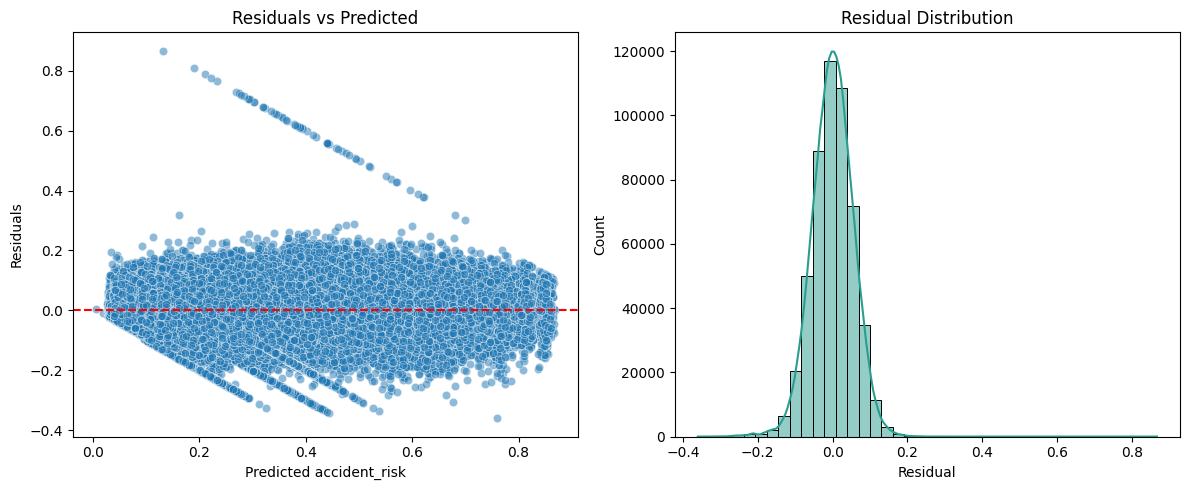

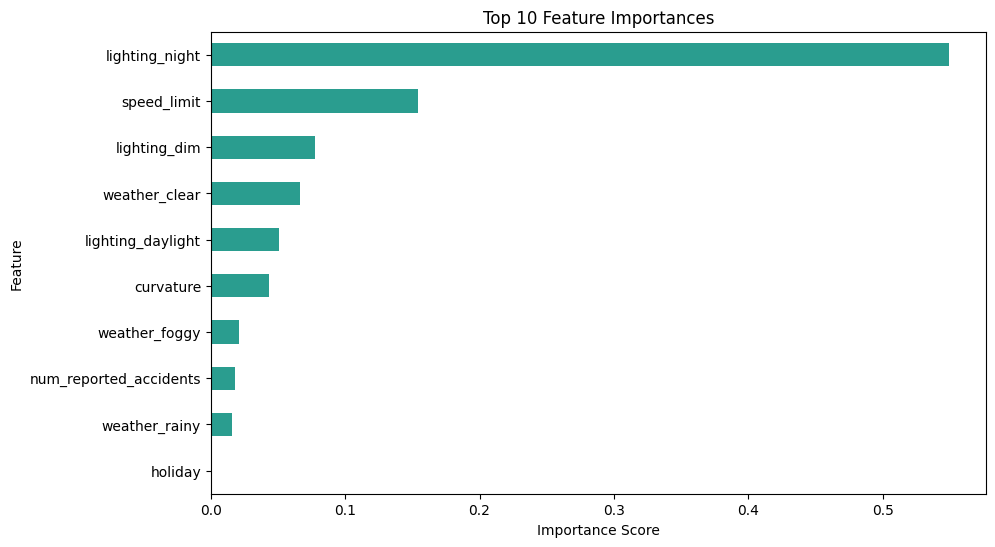

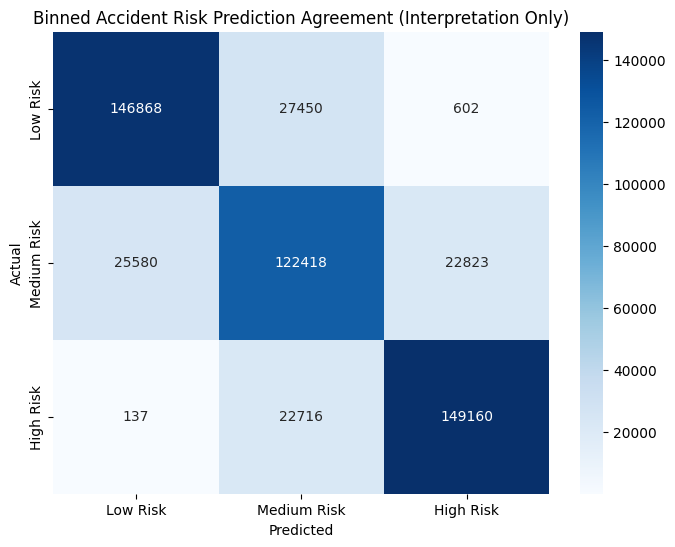


✅ Final model evaluation completed successfully


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

print("\n" + "=" * 60)
print("FINAL MODEL EVALUATION & INTERPRETATION (accident_risk)")
print("=" * 60)

# ==================================================
# Prepare Features & Target
# ==================================================
target = "accident_risk"

X = train_df.drop(columns=[target])
y = train_df[target]

print("\nFeature matrix shape:", X.shape)
print("Target shape:", y.shape)

# Identify categorical and numerical features for preprocessing
numerical_features = X.select_dtypes(include=['int64', 'float64', 'bool']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# ==================================================
# Create and Fit Final Model
# ==================================================
print("\nBuilding and fitting final model with best hyperparameters...")

# Ensure 'study' and 'best_model_name' are available from the previous cell's execution
# This block assumes these variables are correctly set from the Optuna tuning.

if best_model_name == "XGBoost":
    regressor = XGBRegressor(
        **study.best_params,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        # Add enable_categorical=True to handle potential issues with object/category dtypes
        # in XGBoost's internal processing, even after OneHotEncoder.
        enable_categorical=True
    )
elif best_model_name == "RandomForest":
    regressor = RandomForestRegressor(
        **study.best_params,
        random_state=42,
        n_jobs=-1
    )
elif best_model_name == "CatBoost":
    regressor = CatBoostRegressor(
        **study.best_params,
        loss_function="RMSE",
        random_seed=42,
        verbose=0
    )
else:
    raise ValueError("Unsupported model type")

final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

final_model.fit(X, y)
print("✅ Final model (including preprocessor) trained successfully.")

# ==================================================
# Training Performance
# ==================================================
y_pred = final_model.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("\nTraining Performance:")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R\u00b2   : {r2:.4f}")

# ==================================================
# Cross-Validation Performance
# ==================================================
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    final_model,
    X,
    y,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

cv_rmse = -cv_scores

print("\nCross-Validation Performance:")
print("RMSE Scores :", np.round(cv_rmse, 4))
print(f"Mean RMSE  : {cv_rmse.mean():.4f}")
print(f"Std RMSE   : {cv_rmse.std():.4f}")

# ==================================================
# Residual Analysis
# ==================================================
residuals = y - y_pred

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted accident_risk")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")

plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=40, kde=True, color="#2a9d8f")
plt.xlabel("Residual")
plt.title("Residual Distribution")

plt.tight_layout()
plt.show()

# ==================================================
# Feature Importance (If Supported)
# ==================================================
# Extract the regressor from the pipeline for feature importances
regressor_model = final_model.named_steps['regressor']

if hasattr(regressor_model, "feature_importances_"):
    # Get feature names after one-hot encoding
    # Check if 'cat' transformer exists and if it has get_feature_names_out
    if 'cat' in final_model.named_steps['preprocessor'].named_transformers_ and \
       hasattr(final_model.named_steps['preprocessor'].named_transformers_['cat'], 'get_feature_names_out'):
        ohe_feature_names = final_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
    else:
        # Fallback or simplified names if OneHotEncoder is not applicable or not fitted
        ohe_feature_names = [f"cat_{col}_{val}" for col in categorical_features for val in X[col].unique()] # This is a simplification and might not match

    all_feature_names = list(numerical_features) + list(ohe_feature_names)

    feature_importance = pd.Series(
        regressor_model.feature_importances_,
        index=all_feature_names
    ).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    feature_importance.head(10).plot(
        kind="barh",
        color="#2a9d8f"
    )
    plt.gca().invert_yaxis()
    plt.title("Top 10 Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()

# ==================================================
# Binned accident_risk Interpretation (Visualization Only)
# ==================================================
y_true_bins = pd.qcut(
    y,
    q=3,
    labels=["Low Risk", "Medium Risk", "High Risk"]
)

y_pred_bins = pd.qcut(
    y_pred,
    q=3,
    labels=["Low Risk", "Medium Risk", "High Risk"]
)

confusion = pd.crosstab(
    y_true_bins,
    y_pred_bins,
    rownames=["Actual"],
    colnames=["Predicted"]
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title("Binned Accident Risk Prediction Agreement (Interpretation Only)")
plt.show()

print("\n✅ Final model evaluation completed successfully")


GENERATING SUBMISSION
Reloading test IDs from ./playground-series-s5e10/test.csv ...
Number of test IDs: 172585
Test feature matrix shape: (172585, 12)

✅ Saved submission file as: submission.csv

Sample submission:


,id,accident_risk
0,517754,0.293626
1,517755,0.121957
2,517756,0.181231
3,517757,0.314192
4,517758,0.404951


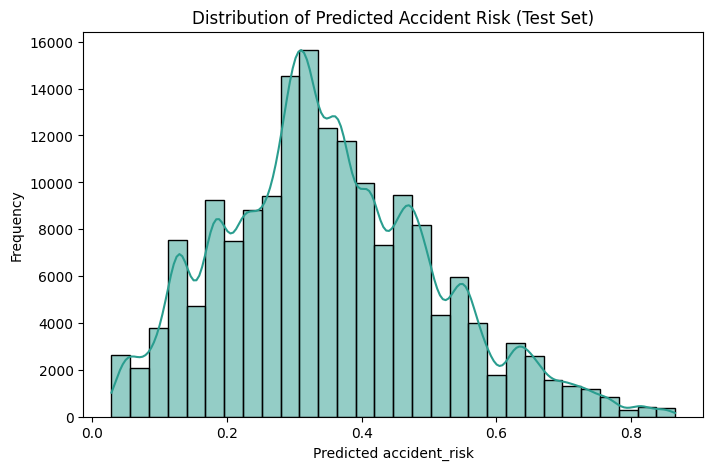


🏁 Submission file is READY for Kaggle upload!


In [ ]:
# ==================================================
# 16. GENERATING SUBMISSION (FINAL & GUARANTEED)
# ==================================================

print("\n" + "=" * 50)
print("GENERATING SUBMISSION")
print("=" * 50)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==================================================
# Reload ORIGINAL test.csv to get IDs (SAFE & CORRECT)
# ==================================================
print("Reloading test IDs from ./playground-series-s5e10/test.csv ...")

test_df_original = pd.read_csv("./playground-series-s5e10/test.csv")
test_ids = test_df_original["id"].copy()

print("Number of test IDs:", len(test_ids))

# ==================================================
# Rebuild X_test to ensure alignment
# ==================================================
X_test = test_df_original.drop(columns=["id"], errors="ignore")

print("Test feature matrix shape:", X_test.shape)

# ==================================================
# Make predictions
# ==================================================
test_pred = final_model.predict(X_test)

# ==================================================
# Create submission DataFrame
# ==================================================
submission = pd.DataFrame({
    "id": test_ids,
    "accident_risk": test_pred
})

# ==================================================
# Save submission file
# ==================================================
submission_filename = "submission.csv"
submission.to_csv(submission_filename, index=False)

print(f"\n✅ Saved submission file as: {submission_filename}")
print("\nSample submission:")
display(submission.head())

# ==================================================
# Plot prediction distribution (Sanity Check)
# ==================================================
plt.figure(figsize=(8, 5))
sns.histplot(
    test_pred,
    bins=30,
    kde=True,
    color="#2a9d8f"
)
plt.title("Distribution of Predicted Accident Risk (Test Set)")
plt.xlabel("Predicted accident_risk")
plt.ylabel("Frequency")
plt.show()

print("\n🏁 Submission file is READY for Kaggle upload!")


In [ ]:
import joblib
from google.colab import files

# Save the final trained model to a .pkl file
model_filename = "final_model.pkl"
joblib.dump(final_model, model_filename)

print(f"✅ Model saved successfully as: {model_filename}")

# To download the file, you can use the following command in a new cell:
files.download(model_filename)


✅ Model saved successfully as: final_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>